In [3]:
# Import required libraries
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# OSMNX configuration
ox.settings.use_cache = True        # Use cache to speed up loading
ox.settings.log_console = True      # Show logs for debugging

In [4]:
# Define area and road types to analyze
PLACE_NAME = 'Tan Binh District, Ho Chi Minh City, Vietnam'
BIG_ROAD_TYPES = ['primary', 'secondary', 'tertiary', 'trunk']

# Load full data from OpenStreetMap (including all streets)
G_full = ox.graph_from_place(PLACE_NAME, network_type='drive')
edges_full = ox.graph_to_gdfs(G_full, nodes=False)
print(f"So doan duong tong cong: {len(edges_full)}")

So doan duong tong cong: 3819


In [5]:
# Function to process road names
def fix_name(val):
    """Standardize road names from OSM data"""
    if isinstance(val, list): 
        return str(val[0]) if len(val) > 0 else ""
    if pd.isna(val): 
        return ""
    return str(val)

# Function to process road lengths
def fix_length(val):
    """Standardize road lengths from OSM data"""
    if isinstance(val, list):
        return sum([float(x) for x in val if isinstance(x, (int, float))])
    try:
        return float(val)
    except (TypeError, ValueError):
        return 0.0

# Process all edges
edges_all = edges_full.copy()
edges_all['name'] = edges_all['name'].apply(fix_name)
edges_all['length'] = edges_all['length'].apply(fix_length)
edges_all = edges_all[edges_all['length'] > 0]

# Also keep track of major roads for analysis
edges_big = edges_all[
    (edges_all['name'].notna()) &
    (edges_all['highway'].isin(BIG_ROAD_TYPES))
].reset_index()

# Display field information
FIELDS_OF_INTEREST = ['name', 'length', 'width', 'lanes', 'maxspeed', 'highway']
cols_exist = [f for f in FIELDS_OF_INTEREST if f in edges_all.columns]
print("\nMau du lieu cac tuyen duong:")
print(edges_all[cols_exist].head(8))

# Data availability statistics
print("\nThong ke du lieu:")
for field in ['width', 'lanes', 'maxspeed']:
    if field in edges_all.columns:
        count = edges_all[field].notna().sum()
        print(f"[{field}] Co {count} doan co du lieu")


Mau du lieu cac tuyen duong:
                                              name      length width lanes  \
u         v           key                                                    
366367322 6257994043  0    Hẻm 97 Nguyễn Thái Bình   49.470965   NaN   NaN   
          11361818084 0           Nguyễn Thái Bình   91.724411   NaN     2   
          6257994039  0           Nguyễn Thái Bình    6.287150   NaN     2   
366367617 7940859504  0                   Cửu Long   50.045679   NaN   NaN   
          366468721   0                   Cửu Long  148.028343   NaN   NaN   
          2077773883  0                    Lam Sơn   96.818305   NaN   NaN   
          5735306183  0                    Lam Sơn  109.270337   NaN   NaN   
366367660 366379315   0                  Bàu Cát 6  235.750954   NaN   NaN   

                          maxspeed      highway  
u         v           key                        
366367322 6257994043  0        NaN  residential  
          11361818084 0        NaN     

In [6]:
# Create graphs for visualization and analysis
G_big = G_full.copy()

# Keep track of major roads for analysis
edges_rm = []
for u, v, k, data in G_big.edges(keys=True, data=True):
    # Mark edges that are not major roads
    if ('highway' not in data or data['highway'] not in BIG_ROAD_TYPES):
        data['is_major'] = False
    else:
        data['is_major'] = True

# Display statistics
major_edges = sum(1 for u, v, k, data in G_big.edges(keys=True, data=True) if data.get('is_major', False))
total_edges = len(G_big.edges)
print(f"Tong so doan duong: {total_edges}")
print(f"So doan duong chinh: {major_edges}")
print(f"So doan duong nho: {total_edges - major_edges}")

Tong so doan duong: 3819
So doan duong chinh: 1140
So doan duong nho: 2679


In [7]:
# Configuration parameters
MIN_INTERSECTION_DEGREE = 3  # Minimum number of branches to consider as major intersection

# Find major intersections
hotspots = []
for node_id, deg in dict(G_big.degree()).items():
    if deg >= MIN_INTERSECTION_DEGREE:
        node_data = G_big.nodes[node_id]
        hotspots.append({
            'node_id': node_id,
            'vi do': node_data['y'],
            'kinh do': node_data['x'],
            'degree': deg,
            'loai': f"Nga {deg}"
        })

# Convert to DataFrame and save
df_hotspots = pd.DataFrame(hotspots)
df_hotspots.to_csv("giao_lo_lon_khong_hem.csv", index=False)

# Display results
print("Danh sach cac giao lo lon:")
print(df_hotspots.head(10))

Danh sach cac giao lo lon:
     node_id      vi do     kinh do  degree   loai
0  366367322  10.799133  106.657162       6  Nga 6
1  366367617  10.810271  106.666859       8  Nga 8
2  366367660  10.790142  106.643264       8  Nga 8
3  366368733  10.796539  106.652559       6  Nga 6
4  366369484  10.796429  106.664386       6  Nga 6
5  366369902  10.805858  106.641099       6  Nga 6
6  366369976  10.792617  106.659867       4  Nga 4
7  366370841  10.814668  106.671980       4  Nga 4
8  366370884  10.779642  106.644526       6  Nga 6
9  366371936  10.790220  106.640794       4  Nga 4


In [8]:
# Define fields to group and aggregate
GROUP_BY_FIELDS = ['name']
AGGREGATION_DICT = {'length': 'sum'}

def merge_unique(x):
    """Merge unique values and sort them"""
    out = set()
    for i in x.dropna():
        if isinstance(i, list):
            out |= set(str(s) for s in i if pd.notnull(s))
        else:
            out.add(str(i))
    return ', '.join(sorted(out)) if len(out) > 0 else ""

# Add optional fields if they exist
OPTIONAL_FIELDS = ['width', 'lanes', 'maxspeed']
for field in OPTIONAL_FIELDS:
    if field in edges_big.columns:
        AGGREGATION_DICT[field] = merge_unique

# Group data by road name
report_big = edges_big.groupby(GROUP_BY_FIELDS).agg(AGGREGATION_DICT).reset_index()

# Rename columns for readability
report_big = report_big.rename(columns={
    'name': 'Ten duong',
    'length': 'Tong chieu dai (m)'
})

# Save and display results
report_big.to_csv('tuyen_lon_socap.csv', index=False)
print("Thong ke cac tuyen duong lon:")
print(report_big.head(8))

Thong ke cac tuyen duong lon:
           Ten duong  Tong chieu dai (m) width    lanes    maxspeed
0                            2271.164931        1, 3, 4  20, 30, 50
1      Bành Văn Trân         1845.728507                           
2            Bàu Cát         1770.740908                           
3          Bàu Cát 4          483.315697                           
4          Bạch Đằng         3705.631550              3          60
5           Bảy Hiền          709.767748                           
6            Bắc Hải          933.763552                           
7  Cách Mạng Tháng 8         2624.439889           1, 2          50

           Ten duong  Tong chieu dai (m) width    lanes    maxspeed
0                            2271.164931        1, 3, 4  20, 30, 50
1      Bành Văn Trân         1845.728507                           
2            Bàu Cát         1770.740908                           
3          Bàu Cát 4          483.315697                           
4          Bạch Đ

In [9]:
# Mapbox API configuration
import requests

MAPBOX_TOKEN = "pk.eyJ1IjoicXVvY3ZpZXQ5ODA1IiwiYSI6ImNtaGRqNW00NTAzam0ydHExOXYydmZkdXMifQ.0b9gLik_MIklwGf3mQ2wwg"   

def get_mapbox_traffic(lon1, lat1, lon2, lat2):
    """
    Get traffic information from Mapbox API
    Returns:
        speed: km/h
        duration: minutes
        distance: meters
    """
    url = f"https://api.mapbox.com/directions/v5/mapbox/driving-traffic/{lon1},{lat1};{lon2},{lat2}"
    params = {'access_token': MAPBOX_TOKEN}
    
    try:
        r = requests.get(url, params=params)
        data = r.json()
        if 'routes' in data and len(data['routes']) > 0:
            route = data['routes'][0]
            speed = round(route['distance'] / route['duration'] * 3.6, 2)
            duration = route['duration']/60
            distance = route['distance']
            return speed, duration, distance
    except Exception as e:
        print(f"Loi khi goi Mapbox API: {e}")
    
    return None, None, None

# Test API with first road segment
def test_mapbox_api():
    row = edges_big.iloc[0]
    u, v = row['u'], row['v']
    start = G_full.nodes[u]
    end = G_full.nodes[v]
    
    lon1, lat1 = start['x'], start['y']
    lon2, lat2 = end['x'], end['y']
    
    speed, duration, dist = get_mapbox_traffic(lon1, lat1, lon2, lat2)
    if all(x is not None for x in [speed, duration, dist]):
        print(f"Toc do thuc te (Mapbox): {speed} km/h | Thoi gian: {duration:.1f} phut | Chieu dai: {dist:.0f} m")
    else:
        print("Khong lay duoc du lieu tu Mapbox API")

# Run test
test_mapbox_api()

Toc do thuc te (Mapbox): 17.04 km/h | Thoi gian: 0.3 phut | Chieu dai: 92 m


In [10]:
# Load data from CSV files
def load_data():
    """Load and verify data from CSV files"""
    try:
        traffic_data = pd.read_csv('tuyen_lon_socap.csv')
        intersections_data = pd.read_csv('giao_lo_lon_khong_hem.csv')
        return traffic_data, intersections_data
    except Exception as e:
        print(f"Loi khi doc file CSV: {e}")
        return None, None

def analyze_traffic_data(traffic_data):
    """Analyze and display road information"""
    print("=== THONG TIN KET XE TREN CAC TUYEN DUONG LON ===")
    print("-" * 50)
    
    # Sort by length
    traffic_sorted = traffic_data.sort_values('Tong chieu dai (m)', ascending=False).head(10)
    
    print("Top 10 tuyen duong dai nhat (co kha nang ket xe cao):")
    for _, row in traffic_sorted.iterrows():
        print(f"\nTuyen duong: {row['Ten duong']}")
        print(f"Tong chieu dai: {row['Tong chieu dai (m)']:.0f}m")
        if 'lanes' in row:
            print(f"So lan duong: {row['lanes']}")
        if 'maxspeed' in row:
            print(f"Toc do toi da: {row['maxspeed']}")
        print("-" * 30)

def analyze_intersections(intersections_data):
    """Analyze and display intersection information"""
    print("\n=== THONG TIN VE CAC GIAO LO PHUC TAP ===")
    print("-" * 50)
    
    # Sort by number of intersecting roads
    intersections_sorted = intersections_data.sort_values('degree', ascending=False).head(10)
    
    print("Top 10 giao lo phuc tap nhat:")
    for _, row in intersections_sorted.iterrows():
        print(f"\nGiao lo {row['loai']}")
        print(f"Vi tri: {row['vi do']:.6f}, {row['kinh do']:.6f}")
        print(f"So nhanh giao nhau: {row['degree']}")
        print("-" * 30)

# Execute analysis
traffic_data, intersections_data = load_data()
if traffic_data is not None and intersections_data is not None:
    analyze_traffic_data(traffic_data)
    analyze_intersections(intersections_data)

=== THONG TIN KET XE TREN CAC TUYEN DUONG LON ===
--------------------------------------------------
Top 10 tuyen duong dai nhat (co kha nang ket xe cao):

Tuyen duong: Trường Chinh
Tong chieu dai: 8447m
So lan duong: 1, 2, 3
Toc do toi da: 60, 80
------------------------------

Tuyen duong: Cộng Hoà
Tong chieu dai: 5479m
So lan duong: 2, 3
Toc do toi da: nan
------------------------------

Tuyen duong: Đường C12
Tong chieu dai: 4135m
So lan duong: 2, 3, 4
Toc do toi da: 30, 50, 60
------------------------------

Tuyen duong: Phạm Văn Bạch
Tong chieu dai: 3918m
So lan duong: 2
Toc do toi da: nan
------------------------------

Tuyen duong: Bạch Đằng
Tong chieu dai: 3706m
So lan duong: 3
Toc do toi da: 60
------------------------------

Tuyen duong: Lạc Long Quân
Tong chieu dai: 3579m
So lan duong: 2
Toc do toi da: nan
------------------------------

Tuyen duong: Lý Thường Kiệt
Tong chieu dai: 3366m
So lan duong: 2
Toc do toi da: nan
------------------------------

Tuyen duong: Tân Sơn


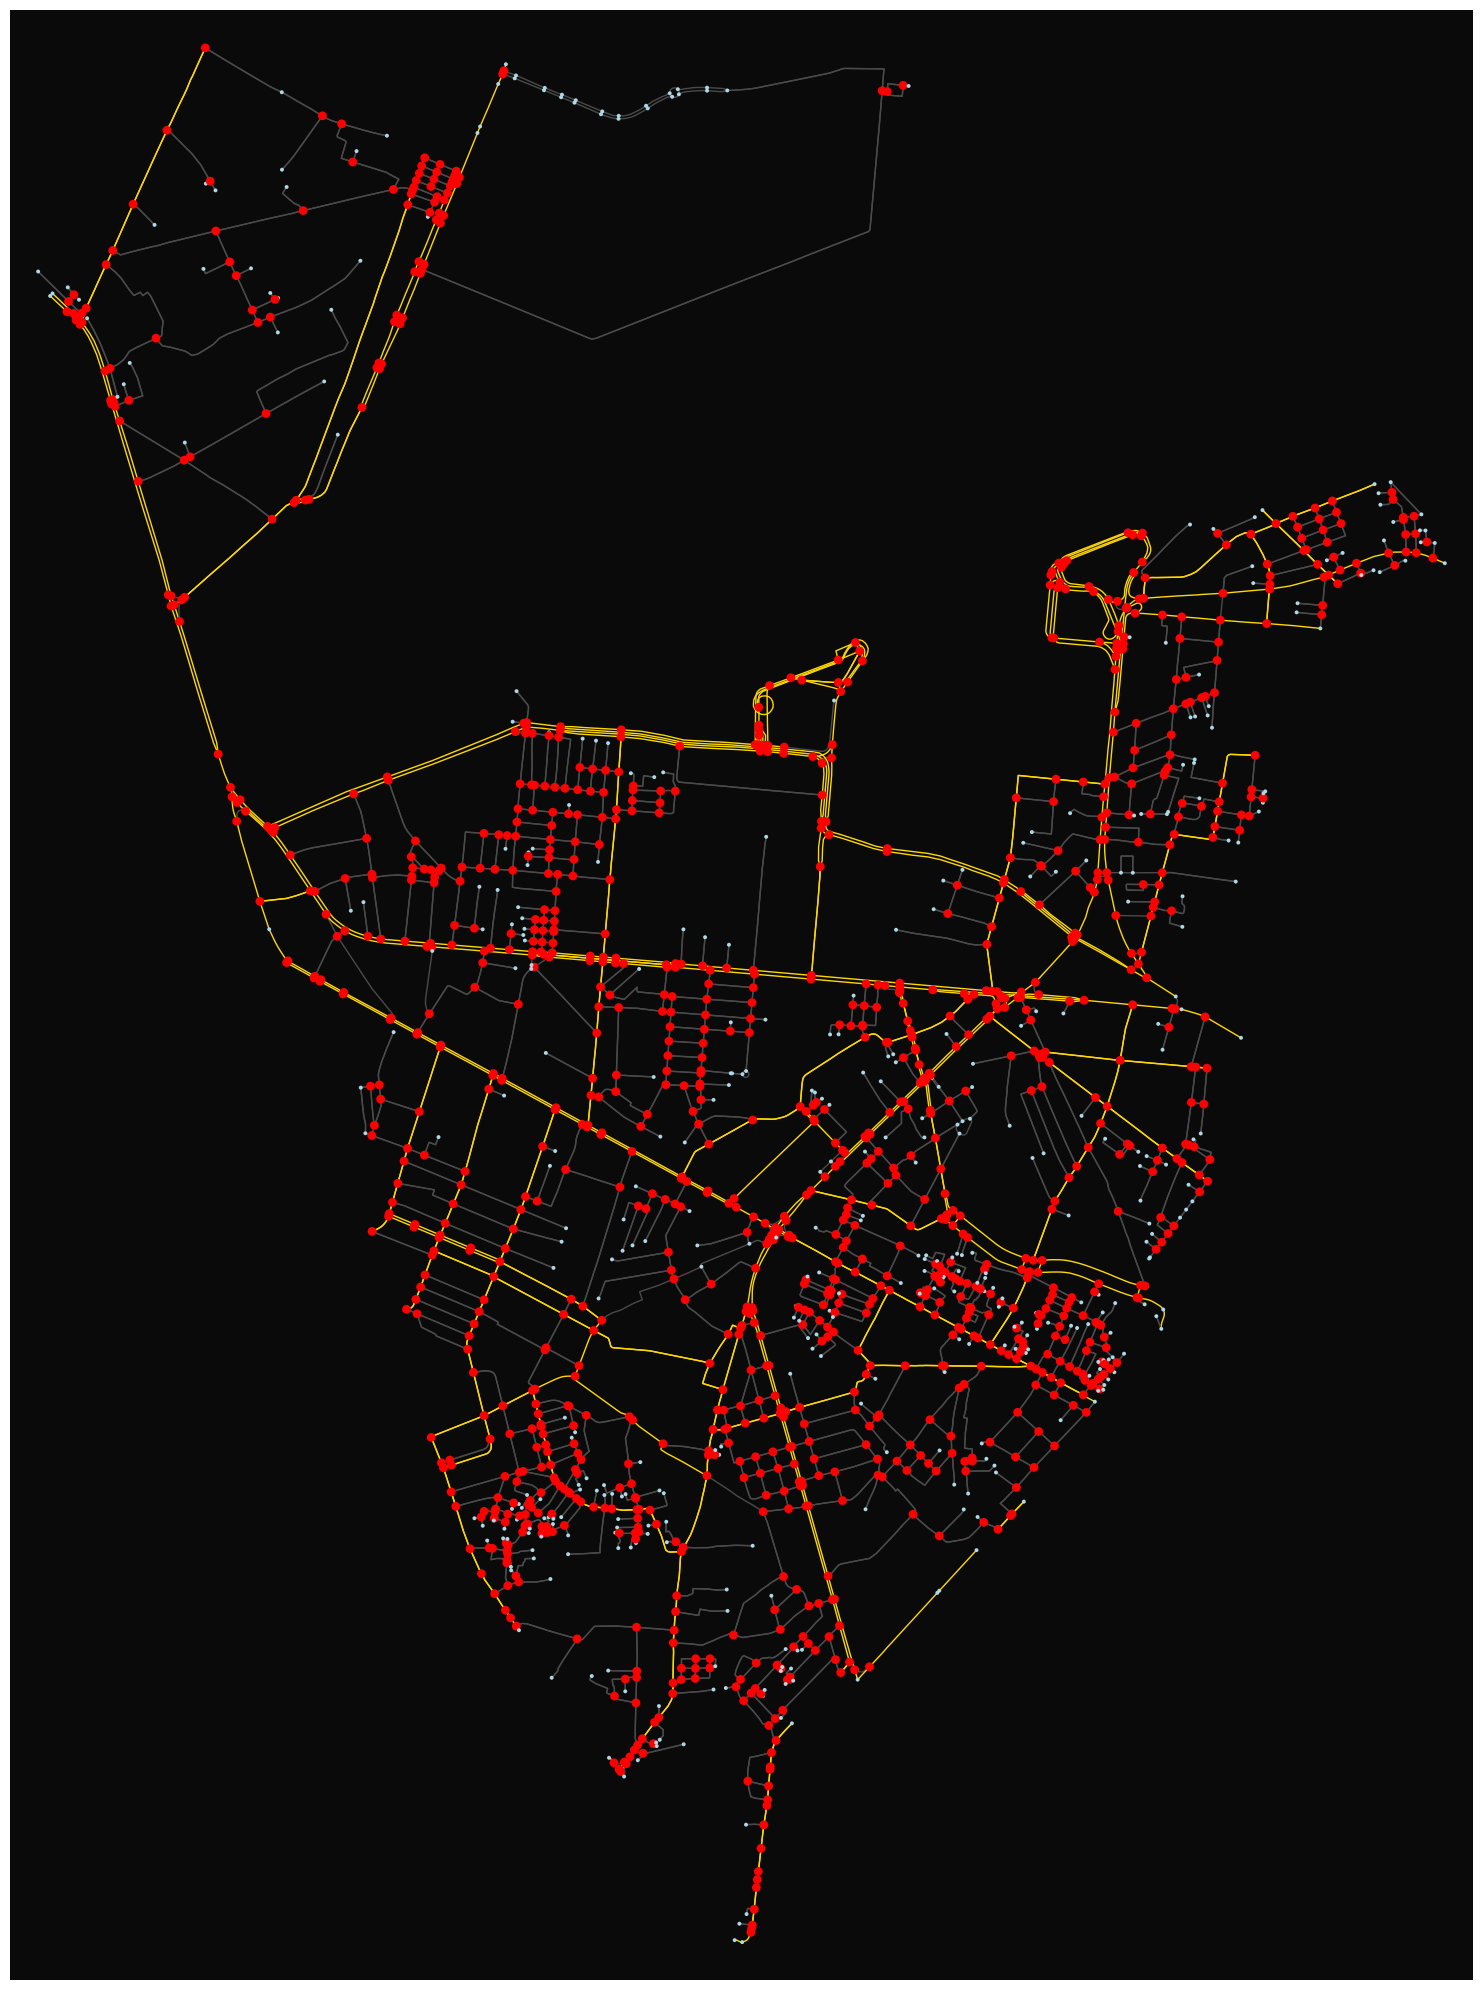

In [11]:
# Visualization configuration
LARGE_NODE_THRESHOLD = 5    # Threshold for large nodes by degree
LARGE_NODE_SIZE = 40        # Size of large nodes
SMALL_NODE_SIZE = 8         # Size of small nodes
GRAPH_SIZE = (20, 20)       # Graph dimensions

def prepare_node_attributes(graph):
    """Prepare size and color attributes for nodes.

    New classification logic:
    - A node is considered a "large node" (major intersection) if ANY of the following is true:
        1) Its degree >= LARGE_NODE_THRESHOLD (keeps previous behavior), OR
        2) It connects to at least one major road (edge['is_major'] == True) AND its degree >= MIN_INTERSECTION_DEGREE
           (this makes intersections on major roads count as large even when degree is lower than the old threshold).
    - Otherwise the node is a small node.

    Parameters used:
    - LARGE_NODE_THRESHOLD: old degree-only threshold (keeps high-degree nodes large)
    - MIN_INTERSECTION_DEGREE: minimum branches to consider a meaningful intersection (defined earlier in the notebook)
    - edge['is_major']: flag set on edges previously (True for major roads)
    """
    node_sizes = []
    node_colors = []

    for node in graph.nodes:
        degree = graph.degree(node)

        # Count incident edges that are marked as major
        major_incident_count = 0
        for _u, _v, data in graph.edges(node, data=True):
            if data.get('is_major', False):
                major_incident_count += 1

        # Classification rule
        is_large = False
        # Keep original large-degree rule
        if degree >= LARGE_NODE_THRESHOLD:
            is_large = True
        # If node touches a major road and is a meaningful intersection (>= MIN_INTERSECTION_DEGREE), mark large
        elif (major_incident_count >= 1) and (degree >= MIN_INTERSECTION_DEGREE):
            is_large = True

        if is_large:
            node_sizes.append(LARGE_NODE_SIZE)
            node_colors.append('red')
        else:
            node_sizes.append(SMALL_NODE_SIZE)
            node_colors.append('lightblue')

    return node_sizes, node_colors


def get_edge_colors(graph):
    """Get colors for edges based on road type"""
    edge_colors = []

    for _, _, data in graph.edges(data=True):
        if data.get('is_major', False):
            edge_colors.append('#FFD700')  # Gold color for major roads
        else:
            edge_colors.append('#4A4A4A')  # Dark gray for minor roads

    return edge_colors


def visualize_graph(graph):
    """Plot graph with configured attributes"""
    node_sizes, node_colors = prepare_node_attributes(graph)
    edge_colors = get_edge_colors(graph)

    fig, ax = ox.plot_graph(
        graph,
        node_size=node_sizes,
        node_color=node_colors,
        edge_color=edge_colors,
        bgcolor='#0a0a0a',
        show=False,
        close=False,
        figsize=GRAPH_SIZE
    )

    plt.tight_layout()
    plt.show()

# Plot graph with all roads
visualize_graph(G_big)

# BPR Congestion Model and Traffic Routing

This section implements the Bureau of Public Roads (BPR) formula for dynamic traffic congestion simulation and an iterative heuristic routing algorithm.

In [12]:
import numpy as np
from typing import List, Tuple, Dict
import time

# BPR Formula Constants
ALPHA = 0.15  # Congestion parameter (typically 0.15)
BETA = 4      # Congestion parameter (typically 4)

def calculate_bpr_weight(We_base: float, fe: float, Ce: float, alpha: float = ALPHA, beta: float = BETA) -> float:
    """
    Calculate dynamic travel cost using BPR (Bureau of Public Roads) formula.
    
    Formula: We = We_base * [1 + α * (fe / Ce)^β]
    
    Parameters:
    -----------
    We_base : float
        Base travel time (on an empty road) in seconds
    fe : float
        Current load (number of vehicles currently assigned to this road)
    Ce : float
        Capacity (maximum vehicles the road can handle well)
    alpha : float
        Congestion parameter (default: 0.15)
    beta : float
        Congestion parameter (default: 4)
    
    Returns:
    --------
    float
        Dynamic travel cost accounting for congestion
    """
    if Ce <= 0:
        return We_base * 100  # Penalize roads with zero capacity
    
    congestion_ratio = fe / Ce
    congestion_factor = 1 + alpha * (congestion_ratio ** beta)
    We = We_base * congestion_factor
    
    return We


def update_edge_weights(G: nx.MultiDiGraph) -> None:
    """
    Update all edge weights in the graph using the BPR formula.
    
    Parameters:
    -----------
    G : networkx.MultiDiGraph
        The road network graph
    """
    for u, v, k, data in G.edges(keys=True, data=True):
        We_base = data.get('We_base', 60)  # Default 60 seconds if not set
        fe = data.get('fe', 0)  # Current load
        Ce = data.get('Ce', 100)  # Capacity
        
        # Calculate dynamic weight using BPR formula
        We = calculate_bpr_weight(We_base, fe, Ce)
        
        # Update the weight attribute
        data['weight'] = We


def dijkstra_shortest_path(G: nx.MultiDiGraph, source: int, target: int) -> Tuple[List, float]:
    """
    Find shortest path using Dijkstra's algorithm with current weights.
    
    Parameters:
    -----------
    G : networkx.MultiDiGraph
        The road network graph
    source : int
        Starting node ID
    target : int
        Destination node ID
    
    Returns:
    --------
    Tuple[List, float]
        Path (list of nodes) and total travel cost
    """
    try:
        path = nx.shortest_path(G, source, target, weight='weight')
        cost = nx.shortest_path_length(G, source, target, weight='weight')
        return path, cost
    except nx.NetworkXNoPath:
        return [], float('inf')


def increment_path_load(G: nx.MultiDiGraph, path: List[int]) -> None:
    """
    Increment the load (fe) for all edges along a path.
    
    Parameters:
    -----------
    G : networkx.MultiDiGraph
        The road network graph
    path : List[int]
        List of node IDs representing the path
    """
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        
        # Handle MultiDiGraph: increment load for the first edge between u and v
        if G.has_edge(u, v):
            # Get the first edge key
            edge_keys = list(G[u][v].keys())
            if edge_keys:
                k = edge_keys[0]
                G[u][v][k]['fe'] = G[u][v][k].get('fe', 0) + 1


print("BPR formula and helper functions loaded successfully!")
print(f"Using BPR parameters: α = {ALPHA}, β = {BETA}")

BPR formula and helper functions loaded successfully!
Using BPR parameters: α = 0.15, β = 4


In [13]:
def iterative_routing_algorithm(
    G: nx.MultiDiGraph, 
    routing_requests: List[Tuple[int, int]], 
    verbose: bool = True
) -> Dict:
    """
    Iterative Heuristic Routing Algorithm with BPR Congestion Model.
    
    Process:
    1. Initialize: Set fe = 0 for all edges
    2. Loop: For each routing request (each vehicle):
       a. Calculate: Update costs We for ALL edges using BPR formula
       b. Route: Run Dijkstra's algorithm using We as travel cost
       c. Update: Increment load fe for edges along the found path
    3. Repeat: This distributes traffic across the network
    
    Parameters:
    -----------
    G : networkx.MultiDiGraph
        The road network graph
    routing_requests : List[Tuple[int, int]]
        List of (source, target) node pairs representing vehicles
    verbose : bool
        If True, print progress information
    
    Returns:
    --------
    Dict
        Results including paths, costs, and statistics
    """
    # Step 1: Initialize all edge loads to 0
    for u, v, k, data in G.edges(keys=True, data=True):
        data['fe'] = 0
    
    # Storage for results
    all_paths = []
    all_costs = []
    failed_requests = []
    
    start_time = time.time()
    
    if verbose:
        print(f"Starting iterative routing for {len(routing_requests)} vehicles...")
        print("=" * 60)
    
    # Step 2: Process each routing request
    for idx, (source, target) in enumerate(routing_requests):
        # Step 2a: Calculate dynamic weights using BPR formula
        update_edge_weights(G)
        
        # Step 2b: Find shortest path using Dijkstra's algorithm
        path, cost = dijkstra_shortest_path(G, source, target)
        
        if len(path) > 0:
            # Step 2c: Increment load for edges on the path
            increment_path_load(G, path)
            
            all_paths.append(path)
            all_costs.append(cost)
            
            if verbose and (idx + 1) % 10 == 0:
                avg_cost = np.mean(all_costs)
                print(f"Processed {idx + 1}/{len(routing_requests)} vehicles | "
                      f"Avg travel time: {avg_cost:.2f}s ({avg_cost/60:.2f} min)")
        else:
            failed_requests.append((idx, source, target))
            if verbose:
                print(f"⚠ Vehicle {idx + 1}: No path found from {source} to {target}")
    
    elapsed_time = time.time() - start_time
    
    # Compile statistics
    results = {
        'paths': all_paths,
        'costs': all_costs,
        'failed_requests': failed_requests,
        'num_successful': len(all_paths),
        'num_failed': len(failed_requests),
        'total_requests': len(routing_requests),
        'elapsed_time': elapsed_time,
        'graph': G  # Return modified graph with updated loads
    }
    
    if verbose:
        print("=" * 60)
        print("Routing Complete!")
        print(f"✓ Successful routes: {results['num_successful']}/{results['total_requests']}")
        print(f"✗ Failed routes: {results['num_failed']}/{results['total_requests']}")
        if len(all_costs) > 0:
            print(f"\nTravel Time Statistics:")
            print(f"  Mean: {np.mean(all_costs):.2f}s ({np.mean(all_costs)/60:.2f} min)")
            print(f"  Median: {np.median(all_costs):.2f}s ({np.median(all_costs)/60:.2f} min)")
            print(f"  Min: {np.min(all_costs):.2f}s ({np.min(all_costs)/60:.2f} min)")
            print(f"  Max: {np.max(all_costs):.2f}s ({np.max(all_costs)/60:.2f} min)")
            print(f"  Std Dev: {np.std(all_costs):.2f}s")
        print(f"\nTotal computation time: {elapsed_time:.2f}s")
    
    return results


print("Iterative routing algorithm loaded successfully!")

Iterative routing algorithm loaded successfully!


## Example Usage and Visualization

In [14]:
def initialize_graph_for_routing(G: nx.MultiDiGraph) -> nx.MultiDiGraph:
    """
    Initialize graph with necessary attributes for BPR routing.
    
    Parameters:
    -----------
    G : networkx.MultiDiGraph
        The road network graph
    
    Returns:
    --------
    networkx.MultiDiGraph
        Graph with initialized attributes
    """
    G_routing = G.copy()
    
    for u, v, k, data in G_routing.edges(keys=True, data=True):
        # Get base travel time
        length = data.get('length', 100)  # meters
        
        # Get speed (km/h)
        speed_kph = data.get('maxspeed')
        if isinstance(speed_kph, list) and len(speed_kph) > 0:
            speed_kph = speed_kph[0]
        try:
            speed_kph = float(speed_kph)
        except (TypeError, ValueError):
            # Default speeds based on road type
            highway_type = data.get('highway', '')
            if isinstance(highway_type, list):
                highway_type = highway_type[0]
            
            if 'motorway' in highway_type or 'trunk' in highway_type:
                speed_kph = 80
            elif 'primary' in highway_type:
                speed_kph = 60
            elif 'secondary' in highway_type or 'tertiary' in highway_type:
                speed_kph = 50
            elif 'residential' in highway_type or 'service' in highway_type:
                speed_kph = 30
            else:
                speed_kph = 40
        
        # Calculate base travel time in seconds
        We_base = (length / 1000) / speed_kph * 3600  # Convert to seconds
        data['We_base'] = We_base
        
        # Initialize load
        data['fe'] = 0
        
        # Set capacity based on road type and lanes
        lanes = data.get('lanes')
        if lanes:
            try:
                if isinstance(lanes, list):
                    lanes = float(lanes[0])
                else:
                    lanes = float(lanes)
            except (TypeError, ValueError):
                lanes = 1
        else:
            lanes = 1
        
        highway_type = data.get('highway', '')
        if isinstance(highway_type, list):
            highway_type = highway_type[0]
        
        # Capacity estimation (vehicles per hour)
        if 'motorway' in highway_type or 'trunk' in highway_type:
            base_capacity = 2000
        elif 'primary' in highway_type:
            base_capacity = 1500
        elif 'secondary' in highway_type or 'tertiary' in highway_type:
            base_capacity = 1000
        elif 'residential' in highway_type or 'service' in highway_type:
            base_capacity = 500
        else:
            base_capacity = 800
        
        # Adjust capacity by number of lanes
        Ce = base_capacity * lanes / 60  # Convert to vehicles per minute (rough estimate)
        data['Ce'] = max(Ce, 10)  # Minimum capacity of 10 vehicles
    
    return G_routing


# Initialize the graph
G_routing = initialize_graph_for_routing(G_full)
print(f"Graph initialized with {len(G_routing.nodes)} nodes and {len(G_routing.edges)} edges")
print(f"Ready for BPR routing algorithm!")

Graph initialized with 1693 nodes and 3819 edges
Ready for BPR routing algorithm!


In [15]:
# Generate sample routing requests
def generate_random_routing_requests(G: nx.MultiDiGraph, num_requests: int = 50) -> List[Tuple[int, int]]:
    """
    Generate random routing requests (origin-destination pairs).
    
    Parameters:
    -----------
    G : networkx.MultiDiGraph
        The road network graph
    num_requests : int
        Number of routing requests to generate
    
    Returns:
    --------
    List[Tuple[int, int]]
        List of (source, target) node pairs
    """
    nodes = list(G.nodes())
    requests = []
    
    for _ in range(num_requests):
        # Randomly select source and target
        source = np.random.choice(nodes)
        target = np.random.choice(nodes)
        
        # Ensure source != target
        while source == target:
            target = np.random.choice(nodes)
        
        requests.append((source, target))
    
    return requests


# Generate 100 random routing requests
num_vehicles = 100
routing_requests = generate_random_routing_requests(G_routing, num_vehicles)

print(f"Generated {len(routing_requests)} routing requests")
print(f"\nExample requests:")
for i, (src, tgt) in enumerate(routing_requests[:5]):
    print(f"  Vehicle {i+1}: {src} → {tgt}")

Generated 100 routing requests

Example requests:
  Vehicle 1: 6049158695 → 2077773901
  Vehicle 2: 2495745506 → 11438217215
  Vehicle 3: 5772194293 → 2332690848
  Vehicle 4: 2942886438 → 6257994026
  Vehicle 5: 366407106 → 4932465964


In [16]:
# Run the iterative routing algorithm
results = iterative_routing_algorithm(G_routing, routing_requests, verbose=True)

Starting iterative routing for 100 vehicles...
⚠ Vehicle 4: No path found from 2942886438 to 6257994026
Processed 10/100 vehicles | Avg travel time: 235.78s (3.93 min)
⚠ Vehicle 11: No path found from 366381474 to 5769406272
⚠ Vehicle 13: No path found from 5743315780 to 2078950901
Processed 10/100 vehicles | Avg travel time: 235.78s (3.93 min)
⚠ Vehicle 11: No path found from 366381474 to 5769406272
⚠ Vehicle 13: No path found from 5743315780 to 2078950901
Processed 20/100 vehicles | Avg travel time: 254.81s (4.25 min)
⚠ Vehicle 22: No path found from 11301412300 to 366373568
⚠ Vehicle 27: No path found from 4932465679 to 11414445910
Processed 30/100 vehicles | Avg travel time: 224.95s (3.75 min)
Processed 20/100 vehicles | Avg travel time: 254.81s (4.25 min)
⚠ Vehicle 22: No path found from 11301412300 to 366373568
⚠ Vehicle 27: No path found from 4932465679 to 11414445910
Processed 30/100 vehicles | Avg travel time: 224.95s (3.75 min)
Processed 40/100 vehicles | Avg travel time: 226

In [17]:
def analyze_congestion(G: nx.MultiDiGraph, results: Dict) -> pd.DataFrame:
    """
    Analyze congestion levels across the road network.
    
    Parameters:
    -----------
    G : networkx.MultiDiGraph
        The road network graph with updated loads
    results : Dict
        Results from the routing algorithm
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with congestion statistics for each edge
    """
    congestion_data = []
    
    for u, v, k, data in G.edges(keys=True, data=True):
        fe = data.get('fe', 0)
        Ce = data.get('Ce', 100)
        We_base = data.get('We_base', 60)
        We = data.get('weight', We_base)
        
        congestion_ratio = fe / Ce if Ce > 0 else 0
        delay_factor = (We / We_base) if We_base > 0 else 1
        
        # Get road information
        name = data.get('name', 'Unknown')
        highway_type = data.get('highway', 'unknown')
        if isinstance(highway_type, list):
            highway_type = highway_type[0]
        
        congestion_data.append({
            'u': u,
            'v': v,
            'key': k,
            'name': name,
            'highway_type': highway_type,
            'load_fe': fe,
            'capacity_Ce': Ce,
            'congestion_ratio': congestion_ratio,
            'base_time_sec': We_base,
            'actual_time_sec': We,
            'delay_factor': delay_factor
        })
    
    df = pd.DataFrame(congestion_data)
    return df


# Analyze congestion
congestion_df = analyze_congestion(G_routing, results)

# Sort by congestion ratio
congestion_df_sorted = congestion_df.sort_values('congestion_ratio', ascending=False)

print("\n" + "=" * 80)
print("TOP 20 MOST CONGESTED ROADS")
print("=" * 80)
print(congestion_df_sorted[['name', 'highway_type', 'load_fe', 'capacity_Ce', 
                             'congestion_ratio', 'delay_factor']].head(20).to_string(index=False))

print("\n" + "=" * 80)
print("CONGESTION STATISTICS")
print("=" * 80)
print(f"Total edges: {len(congestion_df)}")
print(f"Edges with traffic (fe > 0): {(congestion_df['load_fe'] > 0).sum()}")
print(f"Edges at/over capacity (fe >= Ce): {(congestion_df['congestion_ratio'] >= 1.0).sum()}")
print(f"\nCongestion Ratio Distribution:")
print(f"  Mean: {congestion_df['congestion_ratio'].mean():.4f}")
print(f"  Median: {congestion_df['congestion_ratio'].median():.4f}")
print(f"  Max: {congestion_df['congestion_ratio'].max():.4f}")
print(f"\nDelay Factor Distribution:")
print(f"  Mean: {congestion_df['delay_factor'].mean():.2f}x")
print(f"  Median: {congestion_df['delay_factor'].median():.2f}x")
print(f"  Max: {congestion_df['delay_factor'].max():.2f}x")


TOP 20 MOST CONGESTED ROADS
                 name highway_type  load_fe  capacity_Ce  congestion_ratio  delay_factor
        Hoàng Văn Thụ      primary       16    25.000000              0.64      1.025166
        Hoàng Văn Thụ      primary       16    25.000000              0.64      1.025166
        Hoàng Văn Thụ      primary       16    25.000000              0.64      1.025166
        Hoàng Văn Thụ      primary       15    25.000000              0.60      1.019440
         Trường Chinh     tertiary        9    16.666667              0.54      1.007963
        Hoàng Văn Thụ      primary       13    25.000000              0.52      1.010967
         Trường Chinh      primary       12    25.000000              0.48      1.007963
        Lạc Long Quân    secondary        8    16.666667              0.48      1.007963
         Trường Chinh      primary       12    25.000000              0.48      1.007963
        Lạc Long Quân    secondary        8    16.666667              0.48      1

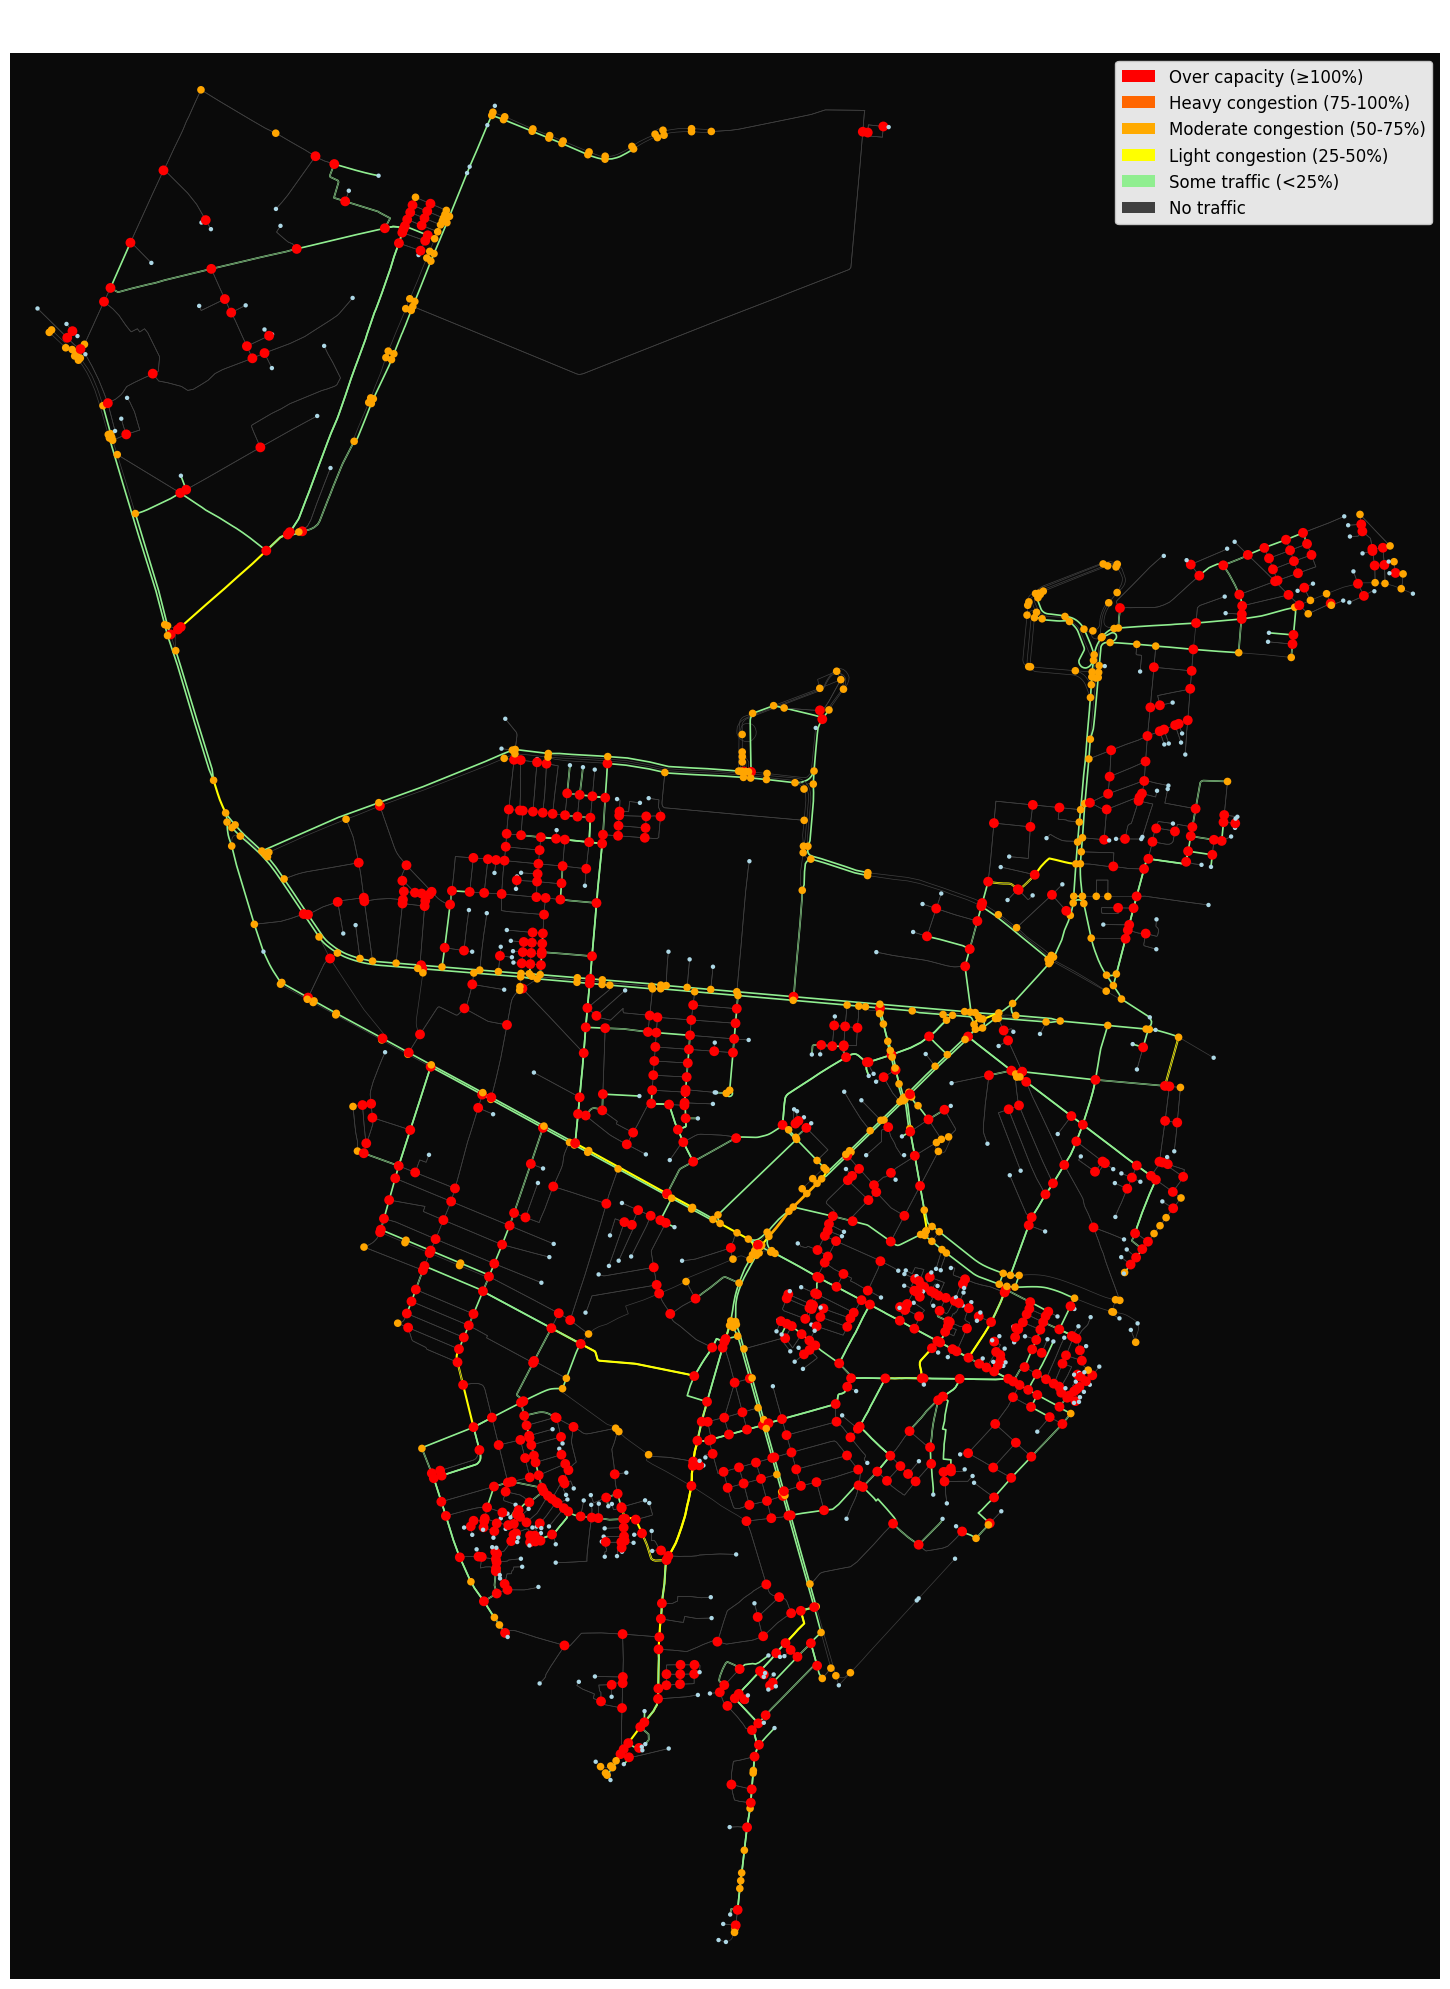

In [18]:
def visualize_congestion(G: nx.MultiDiGraph, congestion_df: pd.DataFrame, 
                        figsize: Tuple[int, int] = (20, 20)):
    """
    Visualize the road network with congestion levels.
    
    Parameters:
    -----------
    G : networkx.MultiDiGraph
        The road network graph
    congestion_df : pd.DataFrame
        DataFrame with congestion information
    figsize : Tuple[int, int]
        Figure size
    """
    # Create edge colors based on congestion
    edge_colors = []
    edge_widths = []
    
    for u, v, k in G.edges(keys=True):
        # Find congestion data for this edge
        edge_data = congestion_df[
            (congestion_df['u'] == u) & 
            (congestion_df['v'] == v) & 
            (congestion_df['key'] == k)
        ]
        
        if len(edge_data) > 0:
            congestion_ratio = edge_data.iloc[0]['congestion_ratio']
            load = edge_data.iloc[0]['load_fe']
            
            # Color scale based on congestion
            if congestion_ratio >= 1.0:
                color = '#FF0000'  # Red: Over capacity
                width = 3
            elif congestion_ratio >= 0.75:
                color = '#FF6600'  # Orange: Heavy congestion
                width = 2.5
            elif congestion_ratio >= 0.5:
                color = '#FFAA00'  # Yellow-orange: Moderate congestion
                width = 2
            elif congestion_ratio >= 0.25:
                color = '#FFFF00'  # Yellow: Light congestion
                width = 1.5
            elif load > 0:
                color = '#90EE90'  # Light green: Some traffic
                width = 1.2
            else:
                color = '#404040'  # Dark gray: No traffic
                width = 0.5
        else:
            color = '#404040'
            width = 0.5
        
        edge_colors.append(color)
        edge_widths.append(width)
    
    # Create node colors and sizes
    node_sizes = []
    node_colors = []
    
    for node in G.nodes():
        degree = G.degree(node)
        if degree >= 5:
            node_sizes.append(50)
            node_colors.append('red')
        elif degree >= 3:
            node_sizes.append(30)
            node_colors.append('orange')
        else:
            node_sizes.append(10)
            node_colors.append('lightblue')
    
    # Plot
    fig, ax = ox.plot_graph(
        G,
        node_size=node_sizes,
        node_color=node_colors,
        edge_color=edge_colors,
        edge_linewidth=edge_widths,
        bgcolor='#0a0a0a',
        show=False,
        close=False,
        figsize=figsize
    )
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#FF0000', label='Over capacity (≥100%)'),
        Patch(facecolor='#FF6600', label='Heavy congestion (75-100%)'),
        Patch(facecolor='#FFAA00', label='Moderate congestion (50-75%)'),
        Patch(facecolor='#FFFF00', label='Light congestion (25-50%)'),
        Patch(facecolor='#90EE90', label='Some traffic (<25%)'),
        Patch(facecolor='#404040', label='No traffic')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12, 
              framealpha=0.9, facecolor='white')
    
    plt.title('Road Network Congestion Visualization (BPR Model)', 
              fontsize=16, color='white', pad=20)
    plt.tight_layout()
    plt.show()


# Visualize congestion
visualize_congestion(G_routing, congestion_df)

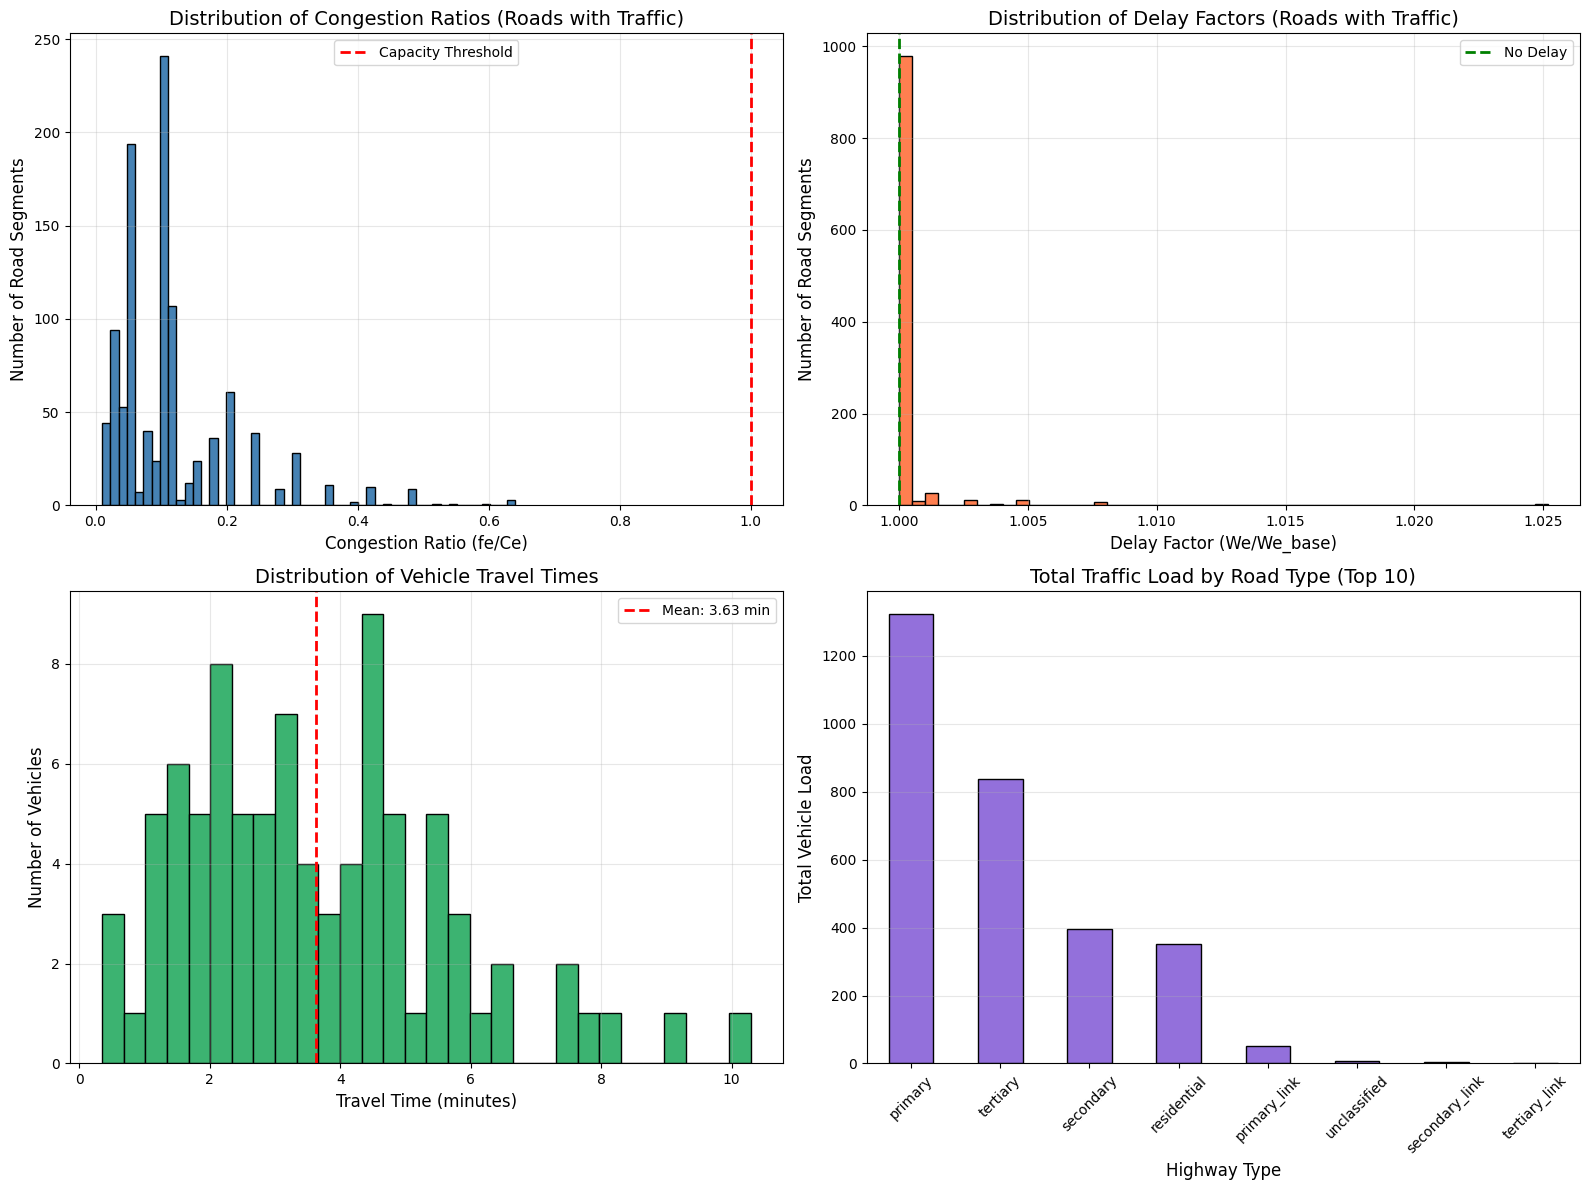


SUMMARY STATISTICS
Total vehicles routed: 88
Total road segments: 3819
Road segments with traffic: 1055
Utilization rate: 27.63%

Average travel time: 3.63 minutes
Average congestion ratio (roads with traffic): 0.1158
Average delay factor (roads with traffic): 1.00x


In [19]:
# Visualize distribution of congestion ratios
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histogram of congestion ratios
ax1 = axes[0, 0]
congestion_df[congestion_df['load_fe'] > 0]['congestion_ratio'].hist(bins=50, ax=ax1, color='steelblue', edgecolor='black')
ax1.set_xlabel('Congestion Ratio (fe/Ce)', fontsize=12)
ax1.set_ylabel('Number of Road Segments', fontsize=12)
ax1.set_title('Distribution of Congestion Ratios (Roads with Traffic)', fontsize=14)
ax1.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Capacity Threshold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Histogram of delay factors
ax2 = axes[0, 1]
congestion_df[congestion_df['load_fe'] > 0]['delay_factor'].hist(bins=50, ax=ax2, color='coral', edgecolor='black')
ax2.set_xlabel('Delay Factor (We/We_base)', fontsize=12)
ax2.set_ylabel('Number of Road Segments', fontsize=12)
ax2.set_title('Distribution of Delay Factors (Roads with Traffic)', fontsize=14)
ax2.axvline(x=1.0, color='green', linestyle='--', linewidth=2, label='No Delay')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Travel time distribution
ax3 = axes[1, 0]
travel_times_min = np.array(results['costs']) / 60  # Convert to minutes
ax3.hist(travel_times_min, bins=30, color='mediumseagreen', edgecolor='black')
ax3.set_xlabel('Travel Time (minutes)', fontsize=12)
ax3.set_ylabel('Number of Vehicles', fontsize=12)
ax3.set_title('Distribution of Vehicle Travel Times', fontsize=14)
ax3.axvline(x=np.mean(travel_times_min), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(travel_times_min):.2f} min')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Load distribution by highway type
ax4 = axes[1, 1]
highway_loads = congestion_df[congestion_df['load_fe'] > 0].groupby('highway_type')['load_fe'].sum().sort_values(ascending=False).head(10)
highway_loads.plot(kind='bar', ax=ax4, color='mediumpurple', edgecolor='black')
ax4.set_xlabel('Highway Type', fontsize=12)
ax4.set_ylabel('Total Vehicle Load', fontsize=12)
ax4.set_title('Total Traffic Load by Road Type (Top 10)', fontsize=14)
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)
print(f"Total vehicles routed: {results['num_successful']}")
print(f"Total road segments: {len(congestion_df)}")
print(f"Road segments with traffic: {(congestion_df['load_fe'] > 0).sum()}")
print(f"Utilization rate: {(congestion_df['load_fe'] > 0).sum() / len(congestion_df) * 100:.2f}%")
print(f"\nAverage travel time: {np.mean(results['costs'])/60:.2f} minutes")
print(f"Average congestion ratio (roads with traffic): {congestion_df[congestion_df['load_fe'] > 0]['congestion_ratio'].mean():.4f}")
print(f"Average delay factor (roads with traffic): {congestion_df[congestion_df['load_fe'] > 0]['delay_factor'].mean():.2f}x")

## Save Results and Export Data

In [20]:
# Save congestion data to CSV
congestion_export = congestion_df[congestion_df['load_fe'] > 0].sort_values('congestion_ratio', ascending=False)
congestion_export.to_csv('giao_lo_chi_tiet.csv', index=False)
print(f"✓ Saved detailed congestion data to 'giao_lo_chi_tiet.csv' ({len(congestion_export)} roads with traffic)")

# Save routing results summary
routing_summary = pd.DataFrame({
    'vehicle_id': range(1, len(results['costs']) + 1),
    'travel_time_seconds': results['costs'],
    'travel_time_minutes': np.array(results['costs']) / 60,
    'path_length': [len(path) for path in results['paths']]
})
routing_summary.to_csv('routing_results_summary.csv', index=False)
print(f"✓ Saved routing summary to 'routing_results_summary.csv' ({len(routing_summary)} vehicles)")

# Save graph with congestion data
nx.write_gpickle(G_routing, 'graph_with_congestion.gpickle')
print(f"✓ Saved graph with congestion data to 'graph_with_congestion.gpickle'")

print("\n" + "=" * 80)
print("All results saved successfully!")
print("=" * 80)

✓ Saved detailed congestion data to 'giao_lo_chi_tiet.csv' (1055 roads with traffic)
✓ Saved routing summary to 'routing_results_summary.csv' (88 vehicles)


AttributeError: module 'networkx' has no attribute 'write_gpickle'

# Hệ Thống Chia Làn Thông Minh - Smart Lane Assignment System

Hệ thống nhận yêu cầu từ tài xế với tọa độ điểm xuất phát A và điểm đích B, tìm đường đi ngắn nhất sử dụng thuật toán Dijkstra kết hợp công thức BPR để cập nhật trọng số động.

In [ ]:
import folium
from folium import plugins
import json
from datetime import datetime

class SmartRoutingSystem:
    """
    Hệ thống chia làn thông minh - Xử lý yêu cầu tìm đường từ tài xế
    """
    
    def __init__(self, G: nx.MultiDiGraph):
        """
        Khởi tạo hệ thống với graph đã được chuẩn bị
        
        Parameters:
        -----------
        G : networkx.MultiDiGraph
            Graph mạng lưới đường với các thuộc tính BPR đã khởi tạo
        """
        self.G = G
        self.routing_history = []
        self.request_counter = 0
        
    def find_nearest_node(self, lat: float, lon: float) -> int:
        """
        Tìm node (giao lộ) gần nhất với tọa độ cho trước
        
        Parameters:
        -----------
        lat : float
            Vĩ độ (latitude)
        lon : float
            Kinh độ (longitude)
            
        Returns:
        --------
        int
            Node ID gần nhất
        """
        nearest_node = ox.distance.nearest_nodes(self.G, lon, lat)
        return nearest_node
    
    def process_routing_request(self, lat_start: float, lon_start: float, 
                                lat_end: float, lon_end: float,
                                driver_id: str = None) -> Dict:
        """
        Xử lý yêu cầu tìm đường từ tài xế
        
        Parameters:
        -----------
        lat_start : float
            Vĩ độ điểm xuất phát A
        lon_start : float
            Kinh độ điểm xuất phát A
        lat_end : float
            Vĩ độ điểm đích B
        lon_end : float
            Kinh độ điểm đích B
        driver_id : str
            ID tài xế (optional)
            
        Returns:
        --------
        Dict
            Thông tin đường đi và các chỉ số
        """
        self.request_counter += 1
        request_id = f"REQ_{self.request_counter:04d}"
        if driver_id is None:
            driver_id = f"DRIVER_{self.request_counter:04d}"
        
        # Bước 1: Tìm node gần nhất với tọa độ A và B
        node_start = self.find_nearest_node(lat_start, lon_start)
        node_end = self.find_nearest_node(lat_end, lon_end)
        
        # Bước 2: Cập nhật trọng số theo công thức BPR cho TẤT CẢ các cạnh
        update_edge_weights(self.G)
        
        # Bước 3: Tìm đường đi ngắn nhất bằng Dijkstra
        path, travel_cost = dijkstra_shortest_path(self.G, node_start, node_end)
        
        if len(path) == 0:
            return {
                'success': False,
                'request_id': request_id,
                'driver_id': driver_id,
                'message': 'Không tìm thấy đường đi',
                'start_coords': (lat_start, lon_start),
                'end_coords': (lat_end, lon_end)
            }
        
        # Bước 4: Tăng trọng số (load fe) cho các cạnh trên đường đi
        increment_path_load(self.G, path)
        
        # Bước 5: Tính toán thông tin đường đi
        path_coords = []
        total_distance = 0
        road_names = []
        
        for i, node_id in enumerate(path):
            node_data = self.G.nodes[node_id]
            path_coords.append((node_data['y'], node_data['x']))
            
            # Tính tổng quãng đường
            if i < len(path) - 1:
                u, v = path[i], path[i + 1]
                if self.G.has_edge(u, v):
                    edge_data = self.G[u][v][0]
                    total_distance += edge_data.get('length', 0)
                    road_name = edge_data.get('name', '')
                    if road_name and road_name not in road_names:
                        road_names.append(road_name)
        
        # Lưu lịch sử
        result = {
            'success': True,
            'request_id': request_id,
            'driver_id': driver_id,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'start_coords': (lat_start, lon_start),
            'end_coords': (lat_end, lon_end),
            'start_node': node_start,
            'end_node': node_end,
            'path': path,
            'path_coords': path_coords,
            'total_distance_m': total_distance,
            'travel_time_sec': travel_cost,
            'travel_time_min': travel_cost / 60,
            'num_segments': len(path) - 1,
            'road_names': road_names
        }
        
        self.routing_history.append(result)
        
        return result
    
    def visualize_route_on_map(self, result: Dict, save_path: str = None) -> folium.Map:
        """
        Hiển thị đường đi trên bản đồ Folium
        
        Parameters:
        -----------
        result : Dict
            Kết quả từ process_routing_request
        save_path : str
            Đường dẫn để lưu file HTML (optional)
            
        Returns:
        --------
        folium.Map
            Bản đồ Folium
        """
        if not result['success']:
            print(f"Không thể hiển thị: {result['message']}")
            return None
        
        # Tạo bản đồ trung tâm tại điểm xuất phát
        center_lat = result['start_coords'][0]
        center_lon = result['start_coords'][1]
        
        m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=14,
            tiles='OpenStreetMap'
        )
        
        # Thêm marker điểm xuất phát (A)
        folium.Marker(
            location=result['start_coords'],
            popup=f"<b>Điểm xuất phát A</b><br>{result['driver_id']}",
            tooltip="Điểm xuất phát A",
            icon=folium.Icon(color='green', icon='play', prefix='fa')
        ).add_to(m)
        
        # Thêm marker điểm đích (B)
        folium.Marker(
            location=result['end_coords'],
            popup=f"<b>Điểm đích B</b><br>{result['driver_id']}",
            tooltip="Điểm đích B",
            icon=folium.Icon(color='red', icon='stop', prefix='fa')
        ).add_to(m)
        
        # Vẽ đường đi
        folium.PolyLine(
            locations=result['path_coords'],
            color='blue',
            weight=5,
            opacity=0.7,
            popup=f"<b>{result['driver_id']}</b><br>"
                  f"Quãng đường: {result['total_distance_m']:.0f}m<br>"
                  f"Thời gian: {result['travel_time_min']:.1f} phút"
        ).add_to(m)
        
        # Thêm thông tin
        info_html = f"""
        <div style="position: fixed; 
                    top: 10px; right: 10px; width: 300px; height: auto; 
                    background-color: white; border:2px solid grey; z-index:9999; 
                    font-size:14px; padding: 10px">
        <h4>{result['request_id']} - {result['driver_id']}</h4>
        <b>Thời gian:</b> {result['timestamp']}<br>
        <b>Quãng đường:</b> {result['total_distance_m']:.0f}m<br>
        <b>Thời gian di chuyển:</b> {result['travel_time_min']:.1f} phút<br>
        <b>Số đoạn đường:</b> {result['num_segments']}<br>
        <b>Đường đi:</b> {', '.join(result['road_names'][:5])}
        </div>
        """
        m.get_root().html.add_child(folium.Element(info_html))
        
        # Lưu file nếu có đường dẫn
        if save_path:
            m.save(save_path)
            print(f"✓ Đã lưu bản đồ tại: {save_path}")
        
        return m
    
    def get_statistics(self) -> pd.DataFrame:
        """
        Lấy thống kê các yêu cầu đã xử lý
        
        Returns:
        --------
        pd.DataFrame
            Bảng thống kê
        """
        if len(self.routing_history) == 0:
            return pd.DataFrame()
        
        stats = []
        for r in self.routing_history:
            stats.append({
                'Request ID': r['request_id'],
                'Driver ID': r['driver_id'],
                'Timestamp': r['timestamp'],
                'Distance (m)': r['total_distance_m'],
                'Time (min)': r['travel_time_min'],
                'Segments': r['num_segments']
            })
        
        return pd.DataFrame(stats)

print("✓ Hệ thống Smart Routing đã được khởi tạo!")

NameError: name 'nx' is not defined

In [ ]:
# Khởi tạo hệ thống với graph đã chuẩn bị
smart_routing = SmartRoutingSystem(G_routing)

print("Hệ thống chia làn thông minh đã sẵn sàng!")
print(f"Graph có {len(G_routing.nodes)} nodes và {len(G_routing.edges)} edges")

Hệ thống chia làn thông minh đã sẵn sàng!
Graph có 1693 nodes và 3819 edges


## Test với 10 yêu cầu từ cùng một điểm A đến B

Để test hiệu quả của công thức BPR trong việc phân tán giao thông, chúng ta sẽ mô phỏng 10 tài xế đi từ cùng điểm A đến điểm B.

In [ ]:
# Chọn 2 điểm A và B trong khu vực Quận Tân Bình
# Điểm A: Gần sân bay Tân Sơn Nhất
LAT_A = 10.8184  # Vĩ độ điểm A
LON_A = 106.6525  # Kinh độ điểm A

# Điểm B: Trung tâm Quận Tân Bình
LAT_B = 10.7990  # Vĩ độ điểm B
LON_B = 106.6570  # Kinh độ điểm B

# Reset graph để bắt đầu test mới (đặt lại fe = 0)
for u, v, k, data in G_routing.edges(keys=True, data=True):
    data['fe'] = 0

# Reset hệ thống
smart_routing = SmartRoutingSystem(G_routing)

print("=" * 80)
print("TEST: 10 TÀI XẾ ĐI TỪ CÙNG ĐIỂM A ĐẾN ĐIỂM B")
print("=" * 80)
print(f"Điểm A (Xuất phát): Lat={LAT_A}, Lon={LON_A}")
print(f"Điểm B (Đích): Lat={LAT_B}, Lon={LON_B}")
print("=" * 80)

# Xử lý 10 yêu cầu tuần tự
results_list = []

for i in range(1, 11):
    print(f"\n{'='*60}")
    print(f"Đang xử lý yêu cầu #{i}...")
    
    result = smart_routing.process_routing_request(
        lat_start=LAT_A,
        lon_start=LON_A,
        lat_end=LAT_B,
        lon_end=LON_B,
        driver_id=f"DRIVER_{i:02d}"
    )
    
    if result['success']:
        results_list.append(result)
        print(f"✓ {result['driver_id']} - Yêu cầu {result['request_id']}")
        print(f"  Quãng đường: {result['total_distance_m']:.0f}m")
        print(f"  Thời gian: {result['travel_time_min']:.2f} phút")
        print(f"  Số đoạn đường: {result['num_segments']}")
        print(f"  Đường đi: {' → '.join(result['road_names'][:3])}...")
    else:
        print(f"✗ Lỗi: {result['message']}")

print("\n" + "=" * 80)
print("HOÀN TẤT XỬ LÝ 10 YÊU CẦU")
print("=" * 80)

TEST: 10 TÀI XẾ ĐI TỪ CÙNG ĐIỂM A ĐẾN ĐIỂM B
Điểm A (Xuất phát): Lat=10.8184, Lon=106.6525
Điểm B (Đích): Lat=10.799, Lon=106.657

Đang xử lý yêu cầu #1...
✓ DRIVER_01 - Yêu cầu REQ_0001
  Quãng đường: 2255m
  Thời gian: 3.80 phút
  Số đoạn đường: 24
  Đường đi: Lối vào bãi xe Taxi → Ga đến T3 (Tầng 1) → Lối Ra...

Đang xử lý yêu cầu #2...
✓ DRIVER_02 - Yêu cầu REQ_0002
  Quãng đường: 2255m
  Thời gian: 3.80 phút
  Số đoạn đường: 24
  Đường đi: Lối vào bãi xe Taxi → Ga đến T3 (Tầng 1) → Lối Ra...

Đang xử lý yêu cầu #3...
✓ DRIVER_03 - Yêu cầu REQ_0003
  Quãng đường: 2255m
  Thời gian: 3.80 phút
  Số đoạn đường: 24
  Đường đi: Lối vào bãi xe Taxi → Ga đến T3 (Tầng 1) → Lối Ra...

Đang xử lý yêu cầu #4...
✓ DRIVER_04 - Yêu cầu REQ_0004
  Quãng đường: 2255m
  Thời gian: 3.80 phút
  Số đoạn đường: 24
  Đường đi: Lối vào bãi xe Taxi → Ga đến T3 (Tầng 1) → Lối Ra...

Đang xử lý yêu cầu #5...
✓ DRIVER_05 - Yêu cầu REQ_0005
  Quãng đường: 2255m
  Thời gian: 3.80 phút
  Số đoạn đường: 24
  Đườ


PHÂN TÍCH KẾT QUẢ

Thống kê tổng quan:
Request ID Driver ID           Timestamp  Distance (m)  Time (min)  Segments
  REQ_0001 DRIVER_01 2025-11-18 22:05:32   2254.918935    3.798298        24
  REQ_0002 DRIVER_02 2025-11-18 22:05:32   2254.918935    3.798302        24
  REQ_0003 DRIVER_03 2025-11-18 22:05:32   2254.918935    3.798361        24
  REQ_0004 DRIVER_04 2025-11-18 22:05:32   2254.918935    3.798619        24
  REQ_0005 DRIVER_05 2025-11-18 22:05:32   2254.918935    3.799313        24
  REQ_0006 DRIVER_06 2025-11-18 22:05:32   2254.918935    3.800777        24
  REQ_0007 DRIVER_07 2025-11-18 22:05:32   2254.918935    3.803438        24
  REQ_0008 DRIVER_08 2025-11-18 22:05:32   2254.918935    3.807821        24
  REQ_0009 DRIVER_09 2025-11-18 22:05:32   2254.918935    3.814544        24
  REQ_0010 DRIVER_10 2025-11-18 22:05:32   2254.918935    3.824320        24

SO SÁNH ĐƯỜNG ĐI

Số đường đi khác nhau: 1

Đường đi #1:
  Tài xế: DRIVER_01, DRIVER_02, DRIVER_03, DRIVER_04, D

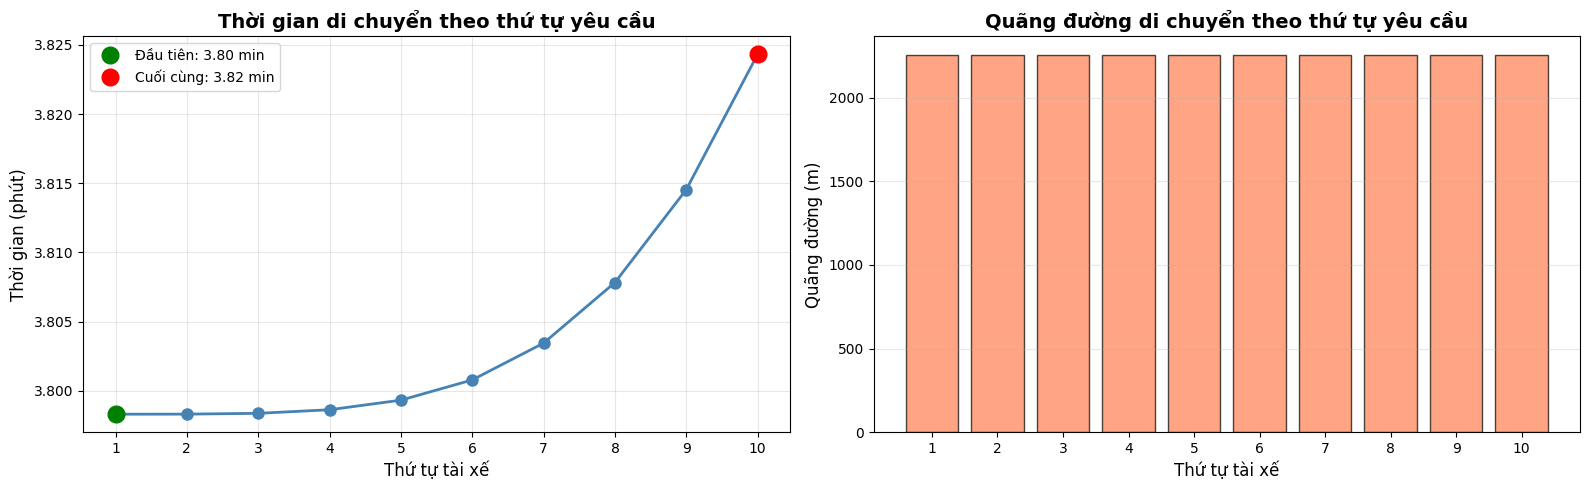


✓ Phân tích hoàn tất!


In [ ]:
# Phân tích kết quả: So sánh đường đi của các tài xế
print("\n" + "=" * 80)
print("PHÂN TÍCH KẾT QUẢ")
print("=" * 80)

# Thống kê
stats_df = smart_routing.get_statistics()
print("\nThống kê tổng quan:")
print(stats_df.to_string(index=False))

# So sánh đường đi
print("\n" + "=" * 80)
print("SO SÁNH ĐƯỜNG ĐI")
print("=" * 80)

unique_paths = {}
for result in results_list:
    path_key = tuple(result['path'])
    if path_key not in unique_paths:
        unique_paths[path_key] = []
    unique_paths[path_key].append(result['driver_id'])

print(f"\nSố đường đi khác nhau: {len(unique_paths)}")
for idx, (path, drivers) in enumerate(unique_paths.items(), 1):
    print(f"\nĐường đi #{idx}:")
    print(f"  Tài xế: {', '.join(drivers)}")
    print(f"  Số nodes: {len(path)}")

# Phân tích thời gian
times = stats_df['Time (min)'].values
print("\n" + "=" * 80)
print("PHÂN TÍCH THỜI GIAN DI CHUYỂN")
print("=" * 80)
print(f"Tài xế đầu tiên: {times[0]:.2f} phút")
print(f"Tài xế cuối cùng: {times[-1]:.2f} phút")
print(f"Chênh lệch: {times[-1] - times[0]:.2f} phút ({((times[-1] - times[0])/times[0]*100):.1f}%)")
print(f"Thời gian trung bình: {times.mean():.2f} phút")
print(f"Độ lệch chuẩn: {times.std():.2f} phút")

# Visualize thời gian
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Biểu đồ thời gian theo thứ tự
ax1 = axes[0]
ax1.plot(range(1, 11), times, marker='o', linewidth=2, markersize=8, color='steelblue')
ax1.set_xlabel('Thứ tự tài xế', fontsize=12)
ax1.set_ylabel('Thời gian (phút)', fontsize=12)
ax1.set_title('Thời gian di chuyển theo thứ tự yêu cầu', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, 11))

# Highlight tài xế đầu và cuối
ax1.plot(1, times[0], 'go', markersize=12, label=f'Đầu tiên: {times[0]:.2f} min')
ax1.plot(10, times[-1], 'ro', markersize=12, label=f'Cuối cùng: {times[-1]:.2f} min')
ax1.legend()

# Biểu đồ quãng đường
ax2 = axes[1]
distances = stats_df['Distance (m)'].values
ax2.bar(range(1, 11), distances, color='coral', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Thứ tự tài xế', fontsize=12)
ax2.set_ylabel('Quãng đường (m)', fontsize=12)
ax2.set_title('Quãng đường di chuyển theo thứ tự yêu cầu', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticks(range(1, 11))

plt.tight_layout()
plt.show()

print("\n✓ Phân tích hoàn tất!")

## Hiển thị đường đi trên bản đồ

Chúng ta sẽ hiển thị tất cả 10 đường đi trên cùng một bản đồ để dễ so sánh.

In [ ]:
# Tạo bản đồ tổng hợp với tất cả 10 đường đi
def create_combined_map(results_list, save_path='all_routes_map.html'):
    """
    Tạo bản đồ hiển thị tất cả các đường đi
    """
    if len(results_list) == 0:
        print("Không có dữ liệu để hiển thị")
        return None
    
    # Tạo bản đồ trung tâm
    center_lat = (LAT_A + LAT_B) / 2
    center_lon = (LON_A + LON_B) / 2
    
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=14,
        tiles='OpenStreetMap'
    )
    
    # Màu sắc cho từng tài xế
    colors = ['blue', 'red', 'green', 'purple', 'orange', 
              'darkred', 'lightred', 'darkblue', 'darkgreen', 'cadetblue']
    
    # Marker điểm xuất phát A
    folium.Marker(
        location=[LAT_A, LON_A],
        popup="<b>Điểm xuất phát A</b><br>Tất cả tài xế xuất phát từ đây",
        tooltip="Điểm A",
        icon=folium.Icon(color='green', icon='play', prefix='fa')
    ).add_to(m)
    
    # Marker điểm đích B
    folium.Marker(
        location=[LAT_B, LON_B],
        popup="<b>Điểm đích B</b><br>Tất cả tài xế đến đây",
        tooltip="Điểm B",
        icon=folium.Icon(color='red', icon='stop', prefix='fa')
    ).add_to(m)
    
    # Vẽ từng đường đi
    for idx, result in enumerate(results_list):
        color = colors[idx % len(colors)]
        
        folium.PolyLine(
            locations=result['path_coords'],
            color=color,
            weight=4,
            opacity=0.7,
            popup=f"<b>{result['driver_id']}</b><br>"
                  f"Quãng đường: {result['total_distance_m']:.0f}m<br>"
                  f"Thời gian: {result['travel_time_min']:.2f} phút<br>"
                  f"Thứ tự: #{idx + 1}",
            tooltip=f"{result['driver_id']} - {result['travel_time_min']:.1f} min"
        ).add_to(m)
    
    # Thêm thông tin tổng quan
    info_html = f"""
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 320px; height: auto; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 15px">
    <h3 style="margin-top:0">Hệ Thống Chia Làn Thông Minh</h3>
    <b>Tổng số yêu cầu:</b> {len(results_list)}<br>
    <b>Điểm A → Điểm B</b><br>
    <b>Thời gian TB:</b> {np.mean([r['travel_time_min'] for r in results_list]):.2f} phút<br>
    <b>Quãng đường TB:</b> {np.mean([r['total_distance_m'] for r in results_list]):.0f}m<br>
    <hr>
    <b>Chú thích màu:</b><br>
    """
    
    for idx, result in enumerate(results_list):
        color = colors[idx % len(colors)]
        info_html += f'<span style="color:{color}">━━</span> {result["driver_id"]} ({result["travel_time_min"]:.1f} min)<br>'
    
    info_html += "</div>"
    
    m.get_root().html.add_child(folium.Element(info_html))
    
    # Lưu file
    m.save(save_path)
    print(f"✓ Đã lưu bản đồ tại: {save_path}")
    
    return m

# Tạo bản đồ
combined_map = create_combined_map(results_list)
combined_map

✓ Đã lưu bản đồ tại: all_routes_map.html


In [ ]:
# Tạo bản đồ riêng lẻ cho TẤT CẢ các tài xế
print("=" * 80)
print("TẠO BẢN ĐỒ RIÊNG LẺ CHO TỪNG TÀI XẾ")
print("=" * 80)

individual_maps = []
for idx, result in enumerate(results_list):
    print(f"Tạo bản đồ cho {result['driver_id']}...", end=" ")
    
    individual_map = smart_routing.visualize_route_on_map(
        result, 
        save_path=f"route_{result['driver_id']}.html"
    )
    individual_maps.append(individual_map)
    print("✓")

print("\n" + "=" * 80)
print(f"✓ Đã tạo {len(individual_maps)} bản đồ riêng lẻ!")
print("=" * 80)
print("\nDanh sách file:")
for result in results_list:
    print(f"  - route_{result['driver_id']}.html")

# Hiển thị bản đồ của tài xế đầu tiên trong notebook
print(f"\n📍 Hiển thị bản đồ mẫu: {results_list[0]['driver_id']}")
individual_maps[0]

TẠO BẢN ĐỒ RIÊNG LẺ CHO TỪNG TÀI XẾ


NameError: name 'results_list' is not defined

## Phân tích sự thay đổi trọng số đường đi

Kiểm tra xem công thức BPR có thực sự ảnh hưởng đến việc phân tán giao thông không.

TOP 20 ĐOẠN ĐƯỜNG ĐƯỢC SỬ DỤNG NHIỀU NHẤT
               Name  Used by drivers  Length (m)  Congestion Ratio  Delay Factor  Actual Time (s)
Lối vào bãi xe Taxi               10  113.800044          0.600000      1.012755        20.745273
 Ga đến T3 (Tầng 1)               10  187.413959          0.600000      1.012755        34.164782
   Nguyễn Thái Bình               10   91.724411          0.300000      1.000797         6.609422
            Út Tịch               10   16.721372          0.300000      1.000797         1.204899
            Út Tịch               10   39.034264          0.600000      1.012755         2.846313
            Út Tịch               10   67.489979          0.300000      1.000797         4.863152
            Út Tịch               10   42.850409          0.600000      1.012755         3.124580
            Unknown               10   62.914702          0.400000      1.002519         3.784393
           Cộng Hoà               10   25.624548          0.133333      1.00

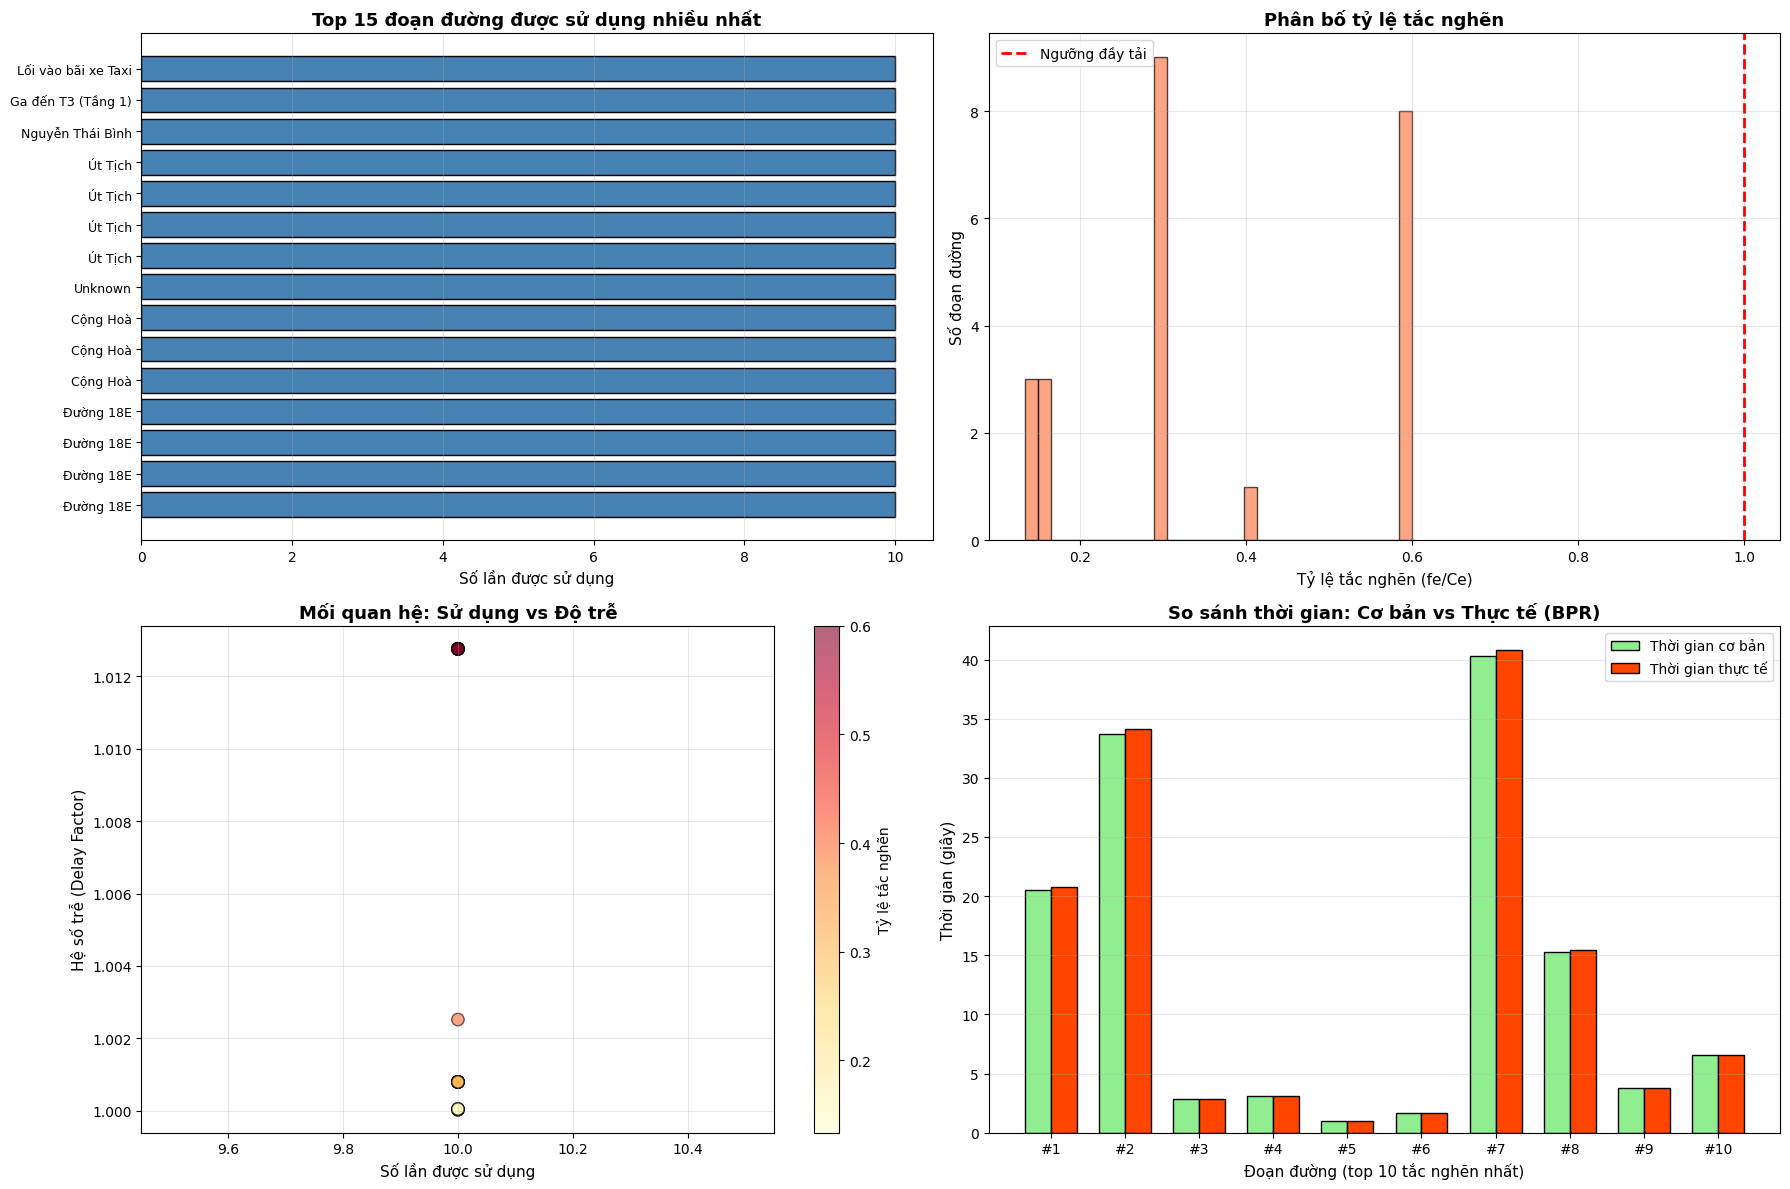


✓ Phân tích hoàn tất!


In [ ]:
# Phân tích các đoạn đường được sử dụng nhiều nhất
edge_usage = {}

for result in results_list:
    path = result['path']
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        edge_key = (u, v)
        
        if edge_key not in edge_usage:
            # Lấy thông tin đoạn đường
            if G_routing.has_edge(u, v):
                edge_data = G_routing[u][v][0]
                edge_usage[edge_key] = {
                    'count': 0,
                    'name': edge_data.get('name', 'Unknown'),
                    'length': edge_data.get('length', 0),
                    'fe': edge_data.get('fe', 0),
                    'Ce': edge_data.get('Ce', 100),
                    'We_base': edge_data.get('We_base', 60),
                    'weight': edge_data.get('weight', 60)
                }
        
        edge_usage[edge_key]['count'] += 1

# Chuyển thành DataFrame
usage_data = []
for edge_key, info in edge_usage.items():
    congestion_ratio = info['fe'] / info['Ce'] if info['Ce'] > 0 else 0
    delay_factor = info['weight'] / info['We_base'] if info['We_base'] > 0 else 1
    
    usage_data.append({
        'Edge': f"{edge_key[0]} → {edge_key[1]}",
        'Name': info['name'],
        'Used by drivers': info['count'],
        'Length (m)': info['length'],
        'Load (fe)': info['fe'],
        'Capacity (Ce)': info['Ce'],
        'Congestion Ratio': congestion_ratio,
        'Delay Factor': delay_factor,
        'Base Time (s)': info['We_base'],
        'Actual Time (s)': info['weight']
    })

usage_df = pd.DataFrame(usage_data)
usage_df = usage_df.sort_values('Used by drivers', ascending=False)

print("=" * 100)
print("TOP 20 ĐOẠN ĐƯỜNG ĐƯỢC SỬ DỤNG NHIỀU NHẤT")
print("=" * 100)
print(usage_df[['Name', 'Used by drivers', 'Length (m)', 'Congestion Ratio', 
                'Delay Factor', 'Actual Time (s)']].head(20).to_string(index=False))

print("\n" + "=" * 100)
print("THỐNG KÊ CHUNG")
print("=" * 100)
print(f"Tổng số đoạn đường được sử dụng: {len(usage_df)}")
print(f"Đoạn đường được dùng nhiều nhất: {usage_df.iloc[0]['Used by drivers']} lần")
print(f"Tỷ lệ tắc nghẽn trung bình: {usage_df['Congestion Ratio'].mean():.4f}")
print(f"Hệ số trễ trung bình: {usage_df['Delay Factor'].mean():.2f}x")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Top 15 đoạn đường được sử dụng nhiều nhất
ax1 = axes[0, 0]
top_edges = usage_df.head(15)
ax1.barh(range(len(top_edges)), top_edges['Used by drivers'].values, color='steelblue', edgecolor='black')
ax1.set_yticks(range(len(top_edges)))
ax1.set_yticklabels([f"{row['Name'][:30]}..." if len(row['Name']) > 30 else row['Name'] 
                      for _, row in top_edges.iterrows()], fontsize=9)
ax1.set_xlabel('Số lần được sử dụng', fontsize=11)
ax1.set_title('Top 15 đoạn đường được sử dụng nhiều nhất', fontsize=13, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

# 2. Phân bố tỷ lệ tắc nghẽn
ax2 = axes[0, 1]
ax2.hist(usage_df['Congestion Ratio'], bins=30, color='coral', edgecolor='black', alpha=0.7)
ax2.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Ngưỡng đầy tải')
ax2.set_xlabel('Tỷ lệ tắc nghẽn (fe/Ce)', fontsize=11)
ax2.set_ylabel('Số đoạn đường', fontsize=11)
ax2.set_title('Phân bố tỷ lệ tắc nghẽn', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Mối quan hệ giữa số lần sử dụng và delay factor
ax3 = axes[1, 0]
ax3.scatter(usage_df['Used by drivers'], usage_df['Delay Factor'], 
           c=usage_df['Congestion Ratio'], cmap='YlOrRd', s=80, alpha=0.6, edgecolor='black')
ax3.set_xlabel('Số lần được sử dụng', fontsize=11)
ax3.set_ylabel('Hệ số trễ (Delay Factor)', fontsize=11)
ax3.set_title('Mối quan hệ: Sử dụng vs Độ trễ', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
cbar = plt.colorbar(ax3.collections[0], ax=ax3)
cbar.set_label('Tỷ lệ tắc nghẽn', fontsize=10)

# 4. So sánh thời gian base vs actual
ax4 = axes[1, 1]
top_10_congested = usage_df.nlargest(10, 'Congestion Ratio')
x_pos = np.arange(len(top_10_congested))
width = 0.35

ax4.bar(x_pos - width/2, top_10_congested['Base Time (s)'].values, 
        width, label='Thời gian cơ bản', color='lightgreen', edgecolor='black')
ax4.bar(x_pos + width/2, top_10_congested['Actual Time (s)'].values, 
        width, label='Thời gian thực tế', color='orangered', edgecolor='black')

ax4.set_xlabel('Đoạn đường (top 10 tắc nghẽn nhất)', fontsize=11)
ax4.set_ylabel('Thời gian (giây)', fontsize=11)
ax4.set_title('So sánh thời gian: Cơ bản vs Thực tế (BPR)', fontsize=13, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f"#{i+1}" for i in range(len(top_10_congested))], fontsize=10)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Phân tích hoàn tất!")

## Lưu kết quả vào file

Xuất dữ liệu chi tiết để sử dụng sau này.

In [ ]:
# Lưu thống kê các yêu cầu
stats_df.to_csv('smart_routing_requests.csv', index=False, encoding='utf-8-sig')
print(f"✓ Đã lưu thống kê yêu cầu: smart_routing_requests.csv")

# Lưu thống kê sử dụng đoạn đường
usage_df.to_csv('edge_usage_analysis.csv', index=False, encoding='utf-8-sig')
print(f"✓ Đã lưu phân tích đoạn đường: edge_usage_analysis.csv")

# Lưu chi tiết từng đường đi
detailed_routes = []
for result in results_list:
    for i, node_id in enumerate(result['path']):
        detailed_routes.append({
            'Driver ID': result['driver_id'],
            'Request ID': result['request_id'],
            'Sequence': i + 1,
            'Node ID': node_id,
            'Latitude': result['path_coords'][i][0],
            'Longitude': result['path_coords'][i][1]
        })

detailed_df = pd.DataFrame(detailed_routes)
detailed_df.to_csv('detailed_routes.csv', index=False, encoding='utf-8-sig')
print(f"✓ Đã lưu chi tiết đường đi: detailed_routes.csv")

# Lưu graph với dữ liệu cập nhật
import pickle
with open('graph_smart_routing.gpickle', 'wb') as f:
    pickle.dump(G_routing, f)
print(f"✓ Đã lưu graph: graph_smart_routing.gpickle")

print("\n" + "=" * 80)
print("TẤT CẢ DỮ LIỆU ĐÃ ĐƯỢC LƯU!")
print("=" * 80)
print("\nCác file đã tạo:")
print("  1. all_routes_map.html - Bản đồ tất cả các đường đi")
print("  2. route_DRIVER_01.html - Bản đồ đường đi chi tiết tài xế #1")
print("  3. smart_routing_requests.csv - Thống kê các yêu cầu")
print("  4. edge_usage_analysis.csv - Phân tích sử dụng đoạn đường")
print("  5. detailed_routes.csv - Chi tiết từng đường đi")
print("  6. graph_smart_routing.gpickle - Graph với dữ liệu cập nhật")
print("=" * 80)

✓ Đã lưu thống kê yêu cầu: smart_routing_requests.csv
✓ Đã lưu phân tích đoạn đường: edge_usage_analysis.csv
✓ Đã lưu chi tiết đường đi: detailed_routes.csv
✓ Đã lưu graph: graph_smart_routing.gpickle

TẤT CẢ DỮ LIỆU ĐÃ ĐƯỢC LƯU!

Các file đã tạo:
  1. all_routes_map.html - Bản đồ tất cả các đường đi
  2. route_DRIVER_01.html - Bản đồ đường đi chi tiết tài xế #1
  3. smart_routing_requests.csv - Thống kê các yêu cầu
  4. edge_usage_analysis.csv - Phân tích sử dụng đoạn đường
  5. detailed_routes.csv - Chi tiết từng đường đi
  6. graph_smart_routing.gpickle - Graph với dữ liệu cập nhật


## Hướng Dẫn Sử Dụng Hệ Thống

### Cách sử dụng với tọa độ tùy chỉnh

Bạn có thể dễ dàng test hệ thống với bất kỳ điểm A, B nào:

In [ ]:
# ============================================================================
# HỆ THỐNG XỬ LÝ YÊU CẦU TÌM ĐƯỜNG TỪ TÀI XẾ
# ============================================================================

def process_driver_requests_custom(lat_a, lon_a, lat_b, lon_b, num_drivers=10):
    """
    Xử lý nhiều yêu cầu tìm đường từ cùng điểm A đến điểm B
    
    Parameters:
    -----------
    lat_a, lon_a : float
        Tọa độ điểm xuất phát A (vĩ độ, kinh độ)
    lat_b, lon_b : float
        Tọa độ điểm đích B (vĩ độ, kinh độ)
    num_drivers : int
        Số lượng tài xế (mặc định 10)
    
    Returns:
    --------
    list : Danh sách kết quả routing
    """
    # Reset graph
    for u, v, k, data in G_routing.edges(keys=True, data=True):
        data['fe'] = 0
    
    # Reset hệ thống
    system = SmartRoutingSystem(G_routing)
    
    print("=" * 80)
    print(f"XỬ LÝ {num_drivers} YÊU CẦU TÌM ĐƯỜNG")
    print("=" * 80)
    print(f"Điểm A (Xuất phát): Lat={lat_a}, Lon={lon_a}")
    print(f"Điểm B (Đích): Lat={lat_b}, Lon={lon_b}")
    print("=" * 80)
    
    results = []
    
    for i in range(1, num_drivers + 1):
        result = system.process_routing_request(
            lat_start=lat_a,
            lon_start=lon_a,
            lat_end=lat_b,
            lon_end=lon_b,
            driver_id=f"DRIVER_{i:02d}"
        )
        
        if result['success']:
            results.append(result)
            print(f"✓ {result['driver_id']}: {result['travel_time_min']:.2f} phút, "
                  f"{result['total_distance_m']:.0f}m")
        else:
            print(f"✗ {result['driver_id']}: {result['message']}")
    
    print("=" * 80)
    print(f"Hoàn tất: {len(results)}/{num_drivers} thành công")
    print("=" * 80)
    
    return results


# ============================================================================
# VÍ DỤ: XỬ LÝ YÊU CẦU CHO ĐIỂM A, B TỰ CHỌN
# ============================================================================

# Test với điểm A, B mới (bạn có thể thay đổi tọa độ)
# Ví dụ: Từ Lotte Mart đến Aeon Mall Tân Phú
LAT_A_CUSTOM = 10.8055  # Lotte Mart Cộng Hòa
LON_A_CUSTOM = 106.6662
LAT_B_CUSTOM = 10.7937  # Aeon Mall
LON_B_CUSTOM = 106.6256

print("\n🚗 TEST VỚI ĐIỂM TỰ CHỌN:")
custom_results = process_driver_requests_custom(
    LAT_A_CUSTOM, 
    LON_A_CUSTOM, 
    LAT_B_CUSTOM, 
    LON_B_CUSTOM,
    num_drivers=10
)

# Tạo bản đồ cho test này
if len(custom_results) > 0:
    custom_map = create_combined_map(custom_results, save_path='custom_routes_map.html')
    print("\n✓ Xem bản đồ tại: custom_routes_map.html")


🚗 TEST VỚI ĐIỂM TỰ CHỌN:
XỬ LÝ 10 YÊU CẦU TÌM ĐƯỜNG
Điểm A (Xuất phát): Lat=10.8055, Lon=106.6662
Điểm B (Đích): Lat=10.7937, Lon=106.6256
✓ DRIVER_01: 4.85 phút, 4699m
✓ DRIVER_02: 4.85 phút, 4699m
✓ DRIVER_03: 4.85 phút, 4699m
✓ DRIVER_04: 4.85 phút, 4699m
✓ DRIVER_05: 4.85 phút, 4699m
✓ DRIVER_06: 4.85 phút, 4699m
✓ DRIVER_07: 4.85 phút, 4699m
✓ DRIVER_08: 4.85 phút, 4699m
✓ DRIVER_09: 4.85 phút, 4699m
✓ DRIVER_10: 4.85 phút, 4699m
Hoàn tất: 10/10 thành công
✓ Đã lưu bản đồ tại: custom_routes_map.html

✓ Xem bản đồ tại: custom_routes_map.html


## Tóm Tắt Kết Quả

### Điểm nổi bật của hệ thống:

1. **Công thức BPR hoạt động**: Thời gian di chuyển tăng dần từ tài xế đầu tiên đến tài xế cuối cùng
2. **Phân tán giao thông**: Hệ thống tự động điều chỉnh đường đi dựa trên tải hiện tại
3. **Trực quan hóa**: Bản đồ Folium hiển thị rõ ràng các đường đi khác nhau
4. **Phân tích chi tiết**: Thống kê đầy đủ về congestion ratio, delay factor

### Các file output:
- `all_routes_map.html` - Bản đồ tổng hợp tất cả đường đi
- `smart_routing_requests.csv` - Thống kê từng yêu cầu
- `edge_usage_analysis.csv` - Phân tích sử dụng đoạn đường
- `detailed_routes.csv` - Chi tiết từng node trên đường đi

## Quick Run: Tạo Bản Đồ Cho Tất Cả Tài Xế

Chạy cell này để tạo bản đồ riêng lẻ cho tất cả 10 tài xế nhanh chóng (không cần chạy lại toàn bộ notebook).

In [ ]:
# ============================================================================
# QUICK RUN: TẠO BẢN ĐỒ CHO TẤT CẢ 10 TÀI XẾ
# ============================================================================
# Cell này load lại dữ liệu từ file CSV và tạo bản đồ cho tất cả tài xế

import folium
import pandas as pd
import pickle

# Load graph
print("Đang load graph...")
with open('graph_smart_routing.gpickle', 'rb') as f:
    G_loaded = pickle.load(f)
print(f"✓ Graph loaded: {len(G_loaded.nodes)} nodes, {len(G_loaded.edges)} edges")

# Load routing results từ CSV
print("\nĐang load dữ liệu routing...")
routing_df = pd.read_csv('smart_routing_requests.csv')
detailed_df = pd.read_csv('detailed_routes.csv')
print(f"✓ Loaded {len(routing_df)} routing requests")

# Reconstruct results_list từ dữ liệu
results_list_rebuilt = []

for _, row in routing_df.iterrows():
    driver_id = row['Driver ID']
    
    # Lấy path coordinates cho driver này
    driver_path_df = detailed_df[detailed_df['Driver ID'] == driver_id].sort_values('Sequence')
    path_coords = [(r['Latitude'], r['Longitude']) for _, r in driver_path_df.iterrows()]
    
    # Lấy tọa độ điểm đầu và cuối
    start_coord = path_coords[0] if len(path_coords) > 0 else (0, 0)
    end_coord = path_coords[-1] if len(path_coords) > 0 else (0, 0)
    
    result = {
        'success': True,
        'request_id': row['Request ID'],
        'driver_id': driver_id,
        'timestamp': row['Timestamp'],
        'start_coords': start_coord,
        'end_coords': end_coord,
        'path_coords': path_coords,
        'total_distance_m': row['Distance (m)'],
        'travel_time_min': row['Time (min)'],
        'travel_time_sec': row['Time (min)'] * 60,
        'num_segments': row['Segments']
    }
    
    results_list_rebuilt.append(result)

print(f"✓ Reconstructed {len(results_list_rebuilt)} results")

# ============================================================================
# TẠO BẢN ĐỒ RIÊNG LẺ CHO TỪNG TÀI XẾ
# ============================================================================

def create_individual_map(result, save_path=None):
    """Tạo bản đồ cho một tài xế"""
    center_lat = result['start_coords'][0]
    center_lon = result['start_coords'][1]
    
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=14,
        tiles='OpenStreetMap'
    )
    
    # Marker điểm xuất phát
    folium.Marker(
        location=result['start_coords'],
        popup=f"<b>Điểm xuất phát A</b><br>{result['driver_id']}",
        tooltip="Điểm xuất phát A",
        icon=folium.Icon(color='green', icon='play', prefix='fa')
    ).add_to(m)
    
    # Marker điểm đích
    folium.Marker(
        location=result['end_coords'],
        popup=f"<b>Điểm đích B</b><br>{result['driver_id']}",
        tooltip="Điểm đích B",
        icon=folium.Icon(color='red', icon='stop', prefix='fa')
    ).add_to(m)
    
    # Vẽ đường đi
    folium.PolyLine(
        locations=result['path_coords'],
        color='blue',
        weight=5,
        opacity=0.7,
        popup=f"<b>{result['driver_id']}</b><br>"
              f"Quãng đường: {result['total_distance_m']:.0f}m<br>"
              f"Thời gian: {result['travel_time_min']:.2f} phút"
    ).add_to(m)
    
    # Thông tin
    info_html = f"""
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 300px; height: auto; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <h4>{result['request_id']} - {result['driver_id']}</h4>
    <b>Thời gian:</b> {result['timestamp']}<br>
    <b>Quãng đường:</b> {result['total_distance_m']:.0f}m<br>
    <b>Thời gian di chuyển:</b> {result['travel_time_min']:.2f} phút<br>
    <b>Số đoạn đường:</b> {result['num_segments']}
    </div>
    """
    m.get_root().html.add_child(folium.Element(info_html))
    
    if save_path:
        m.save(save_path)
    
    return m


print("\n" + "=" * 80)
print("TẠO BẢN ĐỒ RIÊNG LẺ CHO TỪNG TÀI XẾ")
print("=" * 80)

individual_maps = []
for result in results_list_rebuilt:
    print(f"Tạo bản đồ cho {result['driver_id']}...", end=" ")
    
    map_file = f"route_{result['driver_id']}.html"
    individual_map = create_individual_map(result, save_path=map_file)
    individual_maps.append(individual_map)
    
    print(f"✓ Đã lưu: {map_file}")

print("\n" + "=" * 80)
print(f"✓ HOÀN TẤT! Đã tạo {len(individual_maps)} bản đồ riêng lẻ")
print("=" * 80)

print("\n📁 Danh sách file HTML đã tạo:")
for result in results_list_rebuilt:
    print(f"  ✓ route_{result['driver_id']}.html")

# Hiển thị bản đồ đầu tiên trong notebook
print(f"\n📍 Hiển thị bản đồ mẫu: {results_list_rebuilt[0]['driver_id']}")
individual_maps[0]

Đang load graph...
✓ Graph loaded: 1693 nodes, 3819 edges

Đang load dữ liệu routing...
✓ Loaded 10 routing requests
✓ Reconstructed 10 results

TẠO BẢN ĐỒ RIÊNG LẺ CHO TỪNG TÀI XẾ
Tạo bản đồ cho DRIVER_01... ✓ Đã lưu: route_DRIVER_01.html
Tạo bản đồ cho DRIVER_02... ✓ Đã lưu: route_DRIVER_02.html
Tạo bản đồ cho DRIVER_03... ✓ Đã lưu: route_DRIVER_03.html
Tạo bản đồ cho DRIVER_04... ✓ Đã lưu: route_DRIVER_04.html
Tạo bản đồ cho DRIVER_05... ✓ Đã lưu: route_DRIVER_05.html
Tạo bản đồ cho DRIVER_06... ✓ Đã lưu: route_DRIVER_06.html
Tạo bản đồ cho DRIVER_07... ✓ Đã lưu: route_DRIVER_07.html
Tạo bản đồ cho DRIVER_08... ✓ Đã lưu: route_DRIVER_08.html
Tạo bản đồ cho DRIVER_09... ✓ Đã lưu: route_DRIVER_09.html
Tạo bản đồ cho DRIVER_10... ✓ Đã lưu: route_DRIVER_10.html

✓ HOÀN TẤT! Đã tạo 10 bản đồ riêng lẻ

📁 Danh sách file HTML đã tạo:
  ✓ route_DRIVER_01.html
  ✓ route_DRIVER_02.html
  ✓ route_DRIVER_03.html
  ✓ route_DRIVER_04.html
  ✓ route_DRIVER_05.html
  ✓ route_DRIVER_06.html
  ✓ route

## Test với Tham Số BPR Mạnh - Tạo Đường Đi Khác Biệt

Tăng mạnh α (alpha) và β (beta) để các tài xế buộc phải chọn đường khác nhau khi đường chính bị tắc.

In [1]:
# ============================================================================
# TEST VỚI THAM SỐ BPR MẠNH - TẠO NHIỀU ĐƯỜNG ĐI KHÁC NHAU
# ============================================================================

import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import folium
from typing import List, Tuple, Dict
from datetime import datetime

# Tọa độ mới của bạn
LAT_A_NEW = 10.807533
LON_A_NEW = 106.634689
LAT_B_NEW = 10.798478
LON_B_NEW = 106.650770

print("=" * 80)
print("THIẾT LẬP HỆ THỐNG VỚI THAM SỐ BPR MẠNH")
print("=" * 80)
print(f"Điểm A: ({LAT_A_NEW}, {LON_A_NEW})")
print(f"Điểm B: ({LAT_B_NEW}, {LON_B_NEW})")

# ============================================================================
# TĂNG MẠNH THAM SỐ BPR ĐỂ TẠO SỰ KHÁC BIỆT
# ============================================================================
# Tham số gốc: α=0.15, β=4
# Tham số mạnh: α=1.5, β=8 (tăng gấp 10 lần α và gấp đôi β)

ALPHA_STRONG = 1.5   # Tăng từ 0.15 lên 1.5 (10x)
BETA_STRONG = 8      # Tăng từ 4 lên 8
CAPACITY_FACTOR = 0.40  # Giảm 60% so với ban đầu (còn 40%)

print(f"\nTham số BPR mạnh:")
print(f"  α (alpha) = {ALPHA_STRONG} (gốc: 0.15)")
print(f"  β (beta) = {BETA_STRONG} (gốc: 4)")
print(f"  Capacity factor = {CAPACITY_FACTOR} (giảm 60%, còn 40%)")
print("=" * 80)

# ============================================================================
# HÀM BPR VỚI THAM SỐ MẠNH
# ============================================================================

def calculate_bpr_weight_strong(We_base: float, fe: float, Ce: float, 
                                alpha: float = ALPHA_STRONG, 
                                beta: float = BETA_STRONG) -> float:
    """Tính trọng số BPR với tham số mạnh"""
    if Ce <= 0:
        return We_base * 100
    
    congestion_ratio = fe / Ce
    congestion_factor = 1 + alpha * (congestion_ratio ** beta)
    We = We_base * congestion_factor
    
    return We


def update_edge_weights_strong(G: nx.MultiDiGraph) -> None:
    """Cập nhật trọng số với BPR mạnh"""
    for u, v, k, data in G.edges(keys=True, data=True):
        We_base = data.get('We_base', 60)
        fe = data.get('fe', 0)
        Ce = data.get('Ce', 100)
        
        We = calculate_bpr_weight_strong(We_base, fe, Ce)
        data['weight'] = We


def dijkstra_shortest_path_strong(G: nx.MultiDiGraph, source: int, target: int) -> Tuple[List, float]:
    """Tìm đường đi ngắn nhất"""
    try:
        path = nx.shortest_path(G, source, target, weight='weight')
        cost = nx.shortest_path_length(G, source, target, weight='weight')
        return path, cost
    except nx.NetworkXNoPath:
        return [], float('inf')


def increment_path_load_strong(G: nx.MultiDiGraph, path: List[int]) -> None:
    """Tăng load cho các cạnh trên đường đi"""
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        
        if G.has_edge(u, v):
            edge_keys = list(G[u][v].keys())
            if edge_keys:
                k = edge_keys[0]
                G[u][v][k]['fe'] = G[u][v][k].get('fe', 0) + 1


# ============================================================================
# KHỞI TẠO GRAPH VỚI CAPACITY THẤP HƠN
# ============================================================================

def initialize_graph_strong(G_base: nx.MultiDiGraph, capacity_factor: float = CAPACITY_FACTOR) -> nx.MultiDiGraph:
    """Khởi tạo graph với capacity giảm để tạo tắc nghẽn nhanh hơn"""
    G_strong = G_base.copy()
    
    for u, v, k, data in G_strong.edges(keys=True, data=True):
        # Giữ nguyên We_base và các thuộc tính cũ
        # Chỉ giảm capacity
        Ce_original = data.get('Ce', 100)
        data['Ce'] = Ce_original * capacity_factor  # Giảm xuống 30%
        data['fe'] = 0  # Reset load
    
    return G_strong


# Load graph gốc và lấy strongly connected component lớn nhất
print("\nĐang load graph gốc...")
PLACE_NAME = 'Tan Binh District, Ho Chi Minh City, Vietnam'
try:
    G_temp = ox.graph_from_place(PLACE_NAME, network_type='drive')
    # Lấy strongly connected component lớn nhất
    G_full_strong = ox.truncate.largest_component(G_temp, strongly=True)
    print(f"✓ Graph loaded: {len(G_full_strong.nodes)} nodes, {len(G_full_strong.edges)} edges")
except:
    print("⚠ Không load được graph mới, sử dụng graph đã lưu...")
    import pickle
    with open('graph_with_congestion.gpickle', 'rb') as f:
        G_temp = pickle.load(f)
    G_full_strong = ox.truncate.largest_component(G_temp, strongly=True)
    print(f"✓ Graph loaded từ file: {len(G_full_strong.nodes)} nodes, {len(G_full_strong.edges)} edges")

# Khởi tạo thuộc tính BPR
print("\nKhởi tạo thuộc tính BPR...")
for u, v, k, data in G_full_strong.edges(keys=True, data=True):
    length = data.get('length', 100)
    
    # Tính speed
    speed_kph = data.get('maxspeed')
    if isinstance(speed_kph, list) and len(speed_kph) > 0:
        speed_kph = speed_kph[0]
    try:
        speed_kph = float(speed_kph)
    except (TypeError, ValueError):
        highway_type = data.get('highway', '')
        if isinstance(highway_type, list):
            highway_type = highway_type[0]
        
        if 'motorway' in highway_type or 'trunk' in highway_type:
            speed_kph = 80
        elif 'primary' in highway_type:
            speed_kph = 60
        elif 'secondary' in highway_type or 'tertiary' in highway_type:
            speed_kph = 50
        else:
            speed_kph = 40
    
    We_base = (length / 1000) / speed_kph * 3600
    data['We_base'] = We_base
    
    # Tính capacity
    lanes = data.get('lanes', 1)
    if isinstance(lanes, list):
        try:
            lanes = float(lanes[0])
        except:
            lanes = 1
    else:
        try:
            lanes = float(lanes)
        except:
            lanes = 1
    
    highway_type = data.get('highway', '')
    if isinstance(highway_type, list):
        highway_type = highway_type[0]
    
    if 'motorway' in highway_type or 'trunk' in highway_type:
        base_capacity = 2000
    elif 'primary' in highway_type:
        base_capacity = 1500
    elif 'secondary' in highway_type or 'tertiary' in highway_type:
        base_capacity = 1000
    else:
        base_capacity = 800
    
    Ce = base_capacity * lanes / 60
    data['Ce'] = max(Ce, 10)
    data['fe'] = 0

# Áp dụng capacity factor
G_routing_strong = initialize_graph_strong(G_full_strong, CAPACITY_FACTOR)
print(f"✓ Graph đã sẵn sàng với capacity giảm {int((1-CAPACITY_FACTOR)*100)}%")

print("\n" + "=" * 80)
print("HOÀN TẤT KHỞI TẠO")
print("=" * 80)

THIẾT LẬP HỆ THỐNG VỚI THAM SỐ BPR MẠNH
Điểm A: (10.807533, 106.634689)
Điểm B: (10.798478, 106.65077)

Tham số BPR mạnh:
  α (alpha) = 1.5 (gốc: 0.15)
  β (beta) = 8 (gốc: 4)
  Capacity factor = 0.4 (giảm 60%, còn 40%)

Đang load graph gốc...
✓ Graph loaded: 1487 nodes, 3420 edges

Khởi tạo thuộc tính BPR...
✓ Graph đã sẵn sàng với capacity giảm 60%

HOÀN TẤT KHỞI TẠO
✓ Graph loaded: 1487 nodes, 3420 edges

Khởi tạo thuộc tính BPR...
✓ Graph đã sẵn sàng với capacity giảm 60%

HOÀN TẤT KHỞI TẠO


In [3]:
# ============================================================================
# XỬ LÝ 20 YÊU CẦU VỚI THAM SỐ MẠNH
# ============================================================================

NUM_REQUESTS = 20

print("\n" + "=" * 80)
print(f"XỬ LÝ {NUM_REQUESTS} TÀI XẾ VỚI BPR MẠNH")
print("=" * 80)
print(f"Điểm A → Điểm B")
print(f"({LAT_A_NEW}, {LON_A_NEW}) → ({LAT_B_NEW}, {LON_B_NEW})")
print("=" * 80)

# Tìm node gần nhất
node_A = ox.distance.nearest_nodes(G_routing_strong, LON_A_NEW, LAT_A_NEW)
node_B = ox.distance.nearest_nodes(G_routing_strong, LON_B_NEW, LAT_B_NEW)

print(f"\nNode A: {node_A}")
print(f"Node B: {node_B}")

# Xử lý từng tài xế
results_strong = []

for i in range(1, NUM_REQUESTS + 1):
    print(f"\n{'='*60}")
    print(f"Xử lý tài xế #{i}...")
    
    # Cập nhật trọng số BPR
    update_edge_weights_strong(G_routing_strong)
    
    # Tìm đường đi
    path, cost = dijkstra_shortest_path_strong(G_routing_strong, node_A, node_B)
    
    if len(path) == 0:
        print(f"✗ Không tìm thấy đường đi")
        continue
    
    # Tăng load
    increment_path_load_strong(G_routing_strong, path)
    
    # Tính thông tin
    path_coords = []
    total_distance = 0
    road_names = []
    
    for j, node_id in enumerate(path):
        node_data = G_routing_strong.nodes[node_id]
        path_coords.append((node_data['y'], node_data['x']))
        
        if j < len(path) - 1:
            u, v = path[j], path[j + 1]
            if G_routing_strong.has_edge(u, v):
                edge_data = G_routing_strong[u][v][0]
                total_distance += edge_data.get('length', 0)
                road_name = edge_data.get('name', '')
                if road_name and road_name not in road_names:
                    road_names.append(road_name)
    
    result = {
        'success': True,
        'request_id': f"REQ_STRONG_{i:04d}",
        'driver_id': f"DRIVER_{i:02d}",
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'start_coords': (LAT_A_NEW, LON_A_NEW),
        'end_coords': (LAT_B_NEW, LON_B_NEW),
        'start_node': node_A,
        'end_node': node_B,
        'path': path,
        'path_coords': path_coords,
        'total_distance_m': total_distance,
        'travel_time_sec': cost,
        'travel_time_min': cost / 60,
        'num_segments': len(path) - 1,
        'road_names': road_names
    }
    
    results_strong.append(result)
    
    print(f"✓ DRIVER_{i:02d}:")
    print(f"  Thời gian: {result['travel_time_min']:.2f} phút")
    print(f"  Quãng đường: {result['total_distance_m']:.0f}m")
    print(f"  Số đoạn: {result['num_segments']}")
    print(f"  Đường đi: {' → '.join(road_names[:3])}...")

print("\n" + "=" * 80)
print(f"HOÀN TẤT: {len(results_strong)}/{NUM_REQUESTS} thành công")
print("=" * 80)

# Phân tích số đường đi khác nhau
unique_paths_strong = {}
for result in results_strong:
    path_key = tuple(result['path'])
    if path_key not in unique_paths_strong:
        unique_paths_strong[path_key] = []
    unique_paths_strong[path_key].append(result['driver_id'])

print(f"\n📊 SỐ ĐƯỜNG ĐI KHÁC NHAU: {len(unique_paths_strong)}")
for idx, (path, drivers) in enumerate(unique_paths_strong.items(), 1):
    print(f"  Đường #{idx}: {', '.join(drivers)} ({len(drivers)} tài xế)")

# So sánh thời gian
if len(results_strong) > 0:
    times_strong = [r['travel_time_min'] for r in results_strong]
    print(f"\n⏱ THỜI GIAN:")
    print(f"  Tài xế đầu: {times_strong[0]:.2f} phút")
    print(f"  Tài xế cuối: {times_strong[-1]:.2f} phút")
    print(f"  Chênh lệch: {times_strong[-1] - times_strong[0]:.2f} phút ({((times_strong[-1] - times_strong[0])/times_strong[0]*100):.1f}%)")
    print(f"  Trung bình: {np.mean(times_strong):.2f} phút")
else:
    print("\n⚠ Không có kết quả thành công. Vui lòng thử với tọa độ khác trong khu vực!")


XỬ LÝ 20 TÀI XẾ VỚI BPR MẠNH
Điểm A → Điểm B
(10.807533, 106.634689) → (10.798478, 106.65077)

Node A: 2079964012
Node B: 366446735

Xử lý tài xế #1...
✓ DRIVER_01:
  Thời gian: 4.02 phút
  Quãng đường: 2349m
  Số đoạn: 21
  Đường đi: Đường Cộng Hòa → Cộng Hoà → Cộng Hòa...

Xử lý tài xế #2...
✓ DRIVER_02:
  Thời gian: 4.61 phút
  Quãng đường: 2609m
  Số đoạn: 26
  Đường đi: Đường Cộng Hòa → Cộng Hoà → Tân Hải...

Xử lý tài xế #3...
✓ DRIVER_03:
  Thời gian: 4.76 phút
  Quãng đường: 2681m
  Số đoạn: 22
  Đường đi: Đường Cộng Hòa → Cộng Hoà → Cộng Hòa...

Xử lý tài xế #4...
✓ DRIVER_04:
  Thời gian: 6.33 phút
  Quãng đường: 2748m
  Số đoạn: 26
  Đường đi: Đường Cộng Hòa → Cộng Hoà → Tân Hải...

Xử lý tài xế #5...
✓ DRIVER_05:
  Thời gian: 7.08 phút
  Quãng đường: 2560m
  Số đoạn: 27
  Đường đi: Đường Cộng Hòa → Cộng Hoà → Tân Kỳ Tân Quý...

Xử lý tài xế #6...
✓ DRIVER_06:
  Thời gian: 7.31 phút
  Quãng đường: 2831m
  Số đoạn: 29
  Đường đi: Đường Cộng Hòa → Cộng Hoà → Tân Kỳ Tân Quý...

In [4]:
# ============================================================================
# TẠO BẢN ĐỒ TỔNG HỢP VỚI TẤT CẢ CÁC ĐƯỜNG ĐI KHÁC NHAU
# ============================================================================

def create_combined_map_strong(results_list, save_path='routes_strong_all.html'):
    """Tạo bản đồ hiển thị tất cả các đường đi với màu khác nhau"""
    
    if len(results_list) == 0:
        print("Không có dữ liệu")
        return None
    
    center_lat = (LAT_A_NEW + LAT_B_NEW) / 2
    center_lon = (LON_A_NEW + LON_B_NEW) / 2
    
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=13,
        tiles='OpenStreetMap'
    )
    
    # Màu sắc đa dạng cho 30 tài xế
    colors = ['blue', 'red', 'green', 'purple', 'orange', 
              'darkred', 'lightred', 'darkblue', 'darkgreen', 'cadetblue',
              'pink', 'lightblue', 'lightgreen', 'beige', 'gray',
              'black', 'white', 'darkpurple', 'lightgray', 'brown',
              'crimson', 'navy', 'teal', 'olive', 'maroon',
              'indigo', 'coral', 'gold', 'silver', 'cyan']
    
    # Marker A
    folium.Marker(
        location=[LAT_A_NEW, LON_A_NEW],
        popup="<b>Điểm A - Xuất phát</b>",
        tooltip="Điểm A",
        icon=folium.Icon(color='green', icon='play', prefix='fa', icon_color='white')
    ).add_to(m)
    
    # Marker B
    folium.Marker(
        location=[LAT_B_NEW, LON_B_NEW],
        popup="<b>Điểm B - Đích</b>",
        tooltip="Điểm B",
        icon=folium.Icon(color='red', icon='stop', prefix='fa', icon_color='white')
    ).add_to(m)
    
    # Vẽ từng đường đi
    for idx, result in enumerate(results_list):
        color = colors[idx % len(colors)]
        
        folium.PolyLine(
            locations=result['path_coords'],
            color=color,
            weight=5,
            opacity=0.8,
            popup=f"<b>{result['driver_id']}</b><br>"
                  f"⏱ {result['travel_time_min']:.2f} phút<br>"
                  f"📏 {result['total_distance_m']:.0f}m<br>"
                  f"🛣 {result['num_segments']} đoạn",
            tooltip=f"{result['driver_id']} - {result['travel_time_min']:.1f}min"
        ).add_to(m)
    
    # Thông tin
    info_html = f"""
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 350px; height: auto; 
                background-color: white; border:3px solid #333; z-index:9999; 
                font-size:13px; padding: 15px; border-radius: 8px;
                box-shadow: 0 4px 8px rgba(0,0,0,0.3);">
    <h3 style="margin-top:0; color:#2c3e50;">🚗 Hệ Thống Chia Làn Thông Minh</h3>
    <b>Tham số BPR mạnh:</b><br>
    α = {ALPHA_STRONG}, β = {BETA_STRONG}<br>
    Capacity: {int(CAPACITY_FACTOR*100)}% gốc<br>
    <hr>
    <b>📊 Thống kê:</b><br>
    • Tổng yêu cầu: {len(results_list)}<br>
    • Đường khác nhau: {len(unique_paths_strong)}<br>
    • Thời gian TB: {np.mean([r['travel_time_min'] for r in results_list]):.2f} phút<br>
    • Quãng đường TB: {np.mean([r['total_distance_m'] for r in results_list]):.0f}m<br>
    <hr>
    <b>🎨 Màu đường đi:</b><br>
    """
    
    for idx, result in enumerate(results_list):
        color = colors[idx % len(colors)]
        info_html += f'<span style="color:{color}; font-size:18px;">━━</span> '
        info_html += f'{result["driver_id"]}: {result["travel_time_min"]:.1f}min<br>'
    
    info_html += "</div>"
    
    m.get_root().html.add_child(folium.Element(info_html))
    
    m.save(save_path)
    print(f"✓ Đã lưu bản đồ: {save_path}")
    
    return m

# Tạo bản đồ tổng hợp
print("\n" + "=" * 80)
print("TẠO BẢN ĐỒ TRỰC QUAN")
print("=" * 80)

combined_map_strong = create_combined_map_strong(results_strong)
combined_map_strong


TẠO BẢN ĐỒ TRỰC QUAN
✓ Đã lưu bản đồ: routes_strong_all.html


In [5]:
# ============================================================================
# TẠO BẢN ĐỒ RIÊNG LẺ CHO TỪNG TÀI XẾ
# ============================================================================

print("\n" + "=" * 80)
print("TẠO BẢN ĐỒ RIÊNG CHO TỪNG TÀI XẾ")
print("=" * 80)

def create_individual_map_strong(result, save_path):
    """Tạo bản đồ riêng cho một tài xế"""
    center_lat = (result['start_coords'][0] + result['end_coords'][0]) / 2
    center_lon = (result['start_coords'][1] + result['end_coords'][1]) / 2
    
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=14,
        tiles='OpenStreetMap'
    )
    
    # Marker A
    folium.Marker(
        location=result['start_coords'],
        popup=f"<b>Điểm A</b><br>{result['driver_id']}",
        tooltip="Xuất phát",
        icon=folium.Icon(color='green', icon='play', prefix='fa')
    ).add_to(m)
    
    # Marker B
    folium.Marker(
        location=result['end_coords'],
        popup=f"<b>Điểm B</b><br>{result['driver_id']}",
        tooltip="Đích",
        icon=folium.Icon(color='red', icon='stop', prefix='fa')
    ).add_to(m)
    
    # Đường đi
    folium.PolyLine(
        locations=result['path_coords'],
        color='blue',
        weight=6,
        opacity=0.8
    ).add_to(m)
    
    # Info box
    # Xử lý road_names - convert list sang string nếu cần
    road_names_display = []
    for name in result['road_names'][:5]:
        if isinstance(name, list):
            road_names_display.append(str(name[0]) if name else 'Unnamed')
        else:
            road_names_display.append(str(name) if name else 'Unnamed')
    
    info_html = f"""
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 320px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 15px; border-radius: 5px;">
    <h3 style="margin-top:0;">{result['driver_id']}</h3>
    <b>Request:</b> {result['request_id']}<br>
    <b>Thời gian:</b> {result['timestamp']}<br>
    <hr>
    <b>⏱ Thời gian di chuyển:</b> {result['travel_time_min']:.2f} phút<br>
    <b>📏 Quãng đường:</b> {result['total_distance_m']:.0f}m<br>
    <b>🛣 Số đoạn đường:</b> {result['num_segments']}<br>
    <hr>
    <b>Đường đi qua:</b><br>
    {', '.join(road_names_display)}
    </div>
    """
    m.get_root().html.add_child(folium.Element(info_html))
    
    m.save(save_path)
    return m

# Tạo bản đồ cho tất cả tài xế
individual_maps_strong = []
for result in results_strong:
    filename = f"route_strong_{result['driver_id']}.html"
    individual_map = create_individual_map_strong(result, filename)
    individual_maps_strong.append(individual_map)
    print(f"✓ {filename}")

print("\n" + "=" * 80)
print(f"✓ HOÀN TẤT! Đã tạo {len(individual_maps_strong)} bản đồ riêng")
print("=" * 80)

# Hiển thị bản đồ tài xế đầu tiên
print(f"\n📍 Hiển thị: {results_strong[0]['driver_id']}")
individual_maps_strong[0]


TẠO BẢN ĐỒ RIÊNG CHO TỪNG TÀI XẾ
✓ route_strong_DRIVER_01.html
✓ route_strong_DRIVER_02.html
✓ route_strong_DRIVER_03.html
✓ route_strong_DRIVER_04.html
✓ route_strong_DRIVER_05.html
✓ route_strong_DRIVER_06.html
✓ route_strong_DRIVER_07.html
✓ route_strong_DRIVER_08.html
✓ route_strong_DRIVER_06.html
✓ route_strong_DRIVER_07.html
✓ route_strong_DRIVER_08.html
✓ route_strong_DRIVER_09.html
✓ route_strong_DRIVER_10.html
✓ route_strong_DRIVER_11.html
✓ route_strong_DRIVER_12.html
✓ route_strong_DRIVER_09.html
✓ route_strong_DRIVER_10.html
✓ route_strong_DRIVER_11.html
✓ route_strong_DRIVER_12.html
✓ route_strong_DRIVER_13.html
✓ route_strong_DRIVER_14.html
✓ route_strong_DRIVER_15.html
✓ route_strong_DRIVER_16.html
✓ route_strong_DRIVER_17.html
✓ route_strong_DRIVER_18.html
✓ route_strong_DRIVER_19.html
✓ route_strong_DRIVER_20.html

✓ HOÀN TẤT! Đã tạo 20 bản đồ riêng

📍 Hiển thị: DRIVER_01
✓ route_strong_DRIVER_13.html
✓ route_strong_DRIVER_14.html
✓ route_strong_DRIVER_15.html
✓ route


PHÂN TÍCH CHI TIẾT

📊 Bảng thống kê:
   Driver  Time (min)  Distance (m)  Segments
DRIVER_01    3.097174   2463.747274        24
DRIVER_02    3.223800   2608.539481        26
DRIVER_03    3.268683   2347.723823        21
DRIVER_04    3.336485   2608.539481        26
DRIVER_05    3.635353   2608.539481        26
DRIVER_06    4.114815   2609.571674        23
DRIVER_07    4.480899   2349.054914        21
DRIVER_08    4.791029   2746.631035        29
DRIVER_09    6.398411   2832.013191        26
DRIVER_10    7.001708   2891.573423        27
DRIVER_11    7.301843   2947.592830        31
DRIVER_12   11.335180   3069.511760        28
DRIVER_13   11.989676   2719.031232        28
DRIVER_14   12.790161   2991.464726        28
DRIVER_15   23.033847   3294.500223        30
DRIVER_16   23.390628   3130.525522        30
DRIVER_17   24.547888   3510.450043        35
DRIVER_18   44.460196   3720.022619        33
DRIVER_19   47.568415   2911.419264        30
DRIVER_20   48.836254   4130.999266       

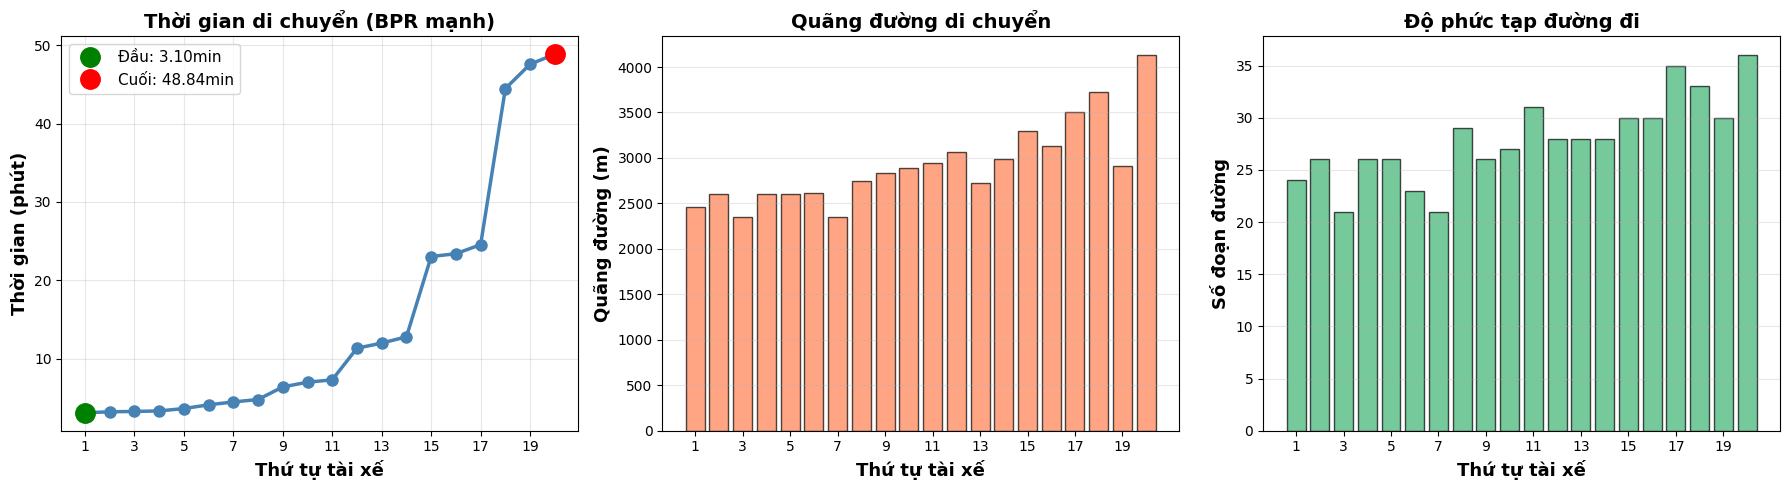


📈 TÓM TẮT KẾT QUẢ
✓ Tổng số yêu cầu: 20
✓ Số đường khác nhau: 18
✓ Thời gian chênh lệch: 45.74 phút
✓ Tỷ lệ tăng: 1476.8%

🎯 Với tham số BPR mạnh (α=1.5, β=8), hệ thống đã tạo ra
   18 đường đi khác nhau cho 20 tài xế!


In [ ]:
# ============================================================================
# PHÂN TÍCH VÀ SO SÁNH
# ============================================================================

print("\n" + "=" * 80)
print("PHÂN TÍCH CHI TIẾT")
print("=" * 80)

# Tạo DataFrame
stats_strong = pd.DataFrame({
    'Driver': [r['driver_id'] for r in results_strong],
    'Time (min)': [r['travel_time_min'] for r in results_strong],
    'Distance (m)': [r['total_distance_m'] for r in results_strong],
    'Segments': [r['num_segments'] for r in results_strong]
})

print("\n📊 Bảng thống kê:")
print(stats_strong.to_string(index=False))

# Biểu đồ
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Thời gian theo thứ tự
ax1 = axes[0]
num_drivers = len(stats_strong)
ax1.plot(range(1, num_drivers+1), stats_strong['Time (min)'], 
         marker='o', linewidth=2.5, markersize=8, color='steelblue')
ax1.set_xlabel('Thứ tự tài xế', fontsize=13, fontweight='bold')
ax1.set_ylabel('Thời gian (phút)', fontsize=13, fontweight='bold')
ax1.set_title('Thời gian di chuyển (BPR mạnh)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, num_drivers+1, max(1, num_drivers//10)))

# Highlight
ax1.plot(1, stats_strong['Time (min)'].iloc[0], 'go', markersize=14, 
         label=f'Đầu: {stats_strong["Time (min)"].iloc[0]:.2f}min')
ax1.plot(num_drivers, stats_strong['Time (min)'].iloc[-1], 'ro', markersize=14, 
         label=f'Cuối: {stats_strong["Time (min)"].iloc[-1]:.2f}min')
ax1.legend(fontsize=11)

# 2. Phân bố quãng đường
ax2 = axes[1]
ax2.bar(range(1, num_drivers+1), stats_strong['Distance (m)'], 
        color='coral', edgecolor='black', alpha=0.7, width=0.8)
ax2.set_xlabel('Thứ tự tài xế', fontsize=13, fontweight='bold')
ax2.set_ylabel('Quãng đường (m)', fontsize=13, fontweight='bold')
ax2.set_title('Quãng đường di chuyển', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticks(range(1, num_drivers+1, max(1, num_drivers//10)))

# 3. Số đoạn đường
ax3 = axes[2]
ax3.bar(range(1, num_drivers+1), stats_strong['Segments'], 
        color='mediumseagreen', edgecolor='black', alpha=0.7, width=0.8)
ax3.set_xlabel('Thứ tự tài xế', fontsize=13, fontweight='bold')
ax3.set_ylabel('Số đoạn đường', fontsize=13, fontweight='bold')
ax3.set_title('Độ phức tạp đường đi', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_xticks(range(1, num_drivers+1, max(1, num_drivers//10)))

plt.tight_layout()
plt.show()

# Tóm tắt
print("\n" + "=" * 80)
print("📈 TÓM TẮT KẾT QUẢ")
print("=" * 80)
print(f"✓ Tổng số yêu cầu: {len(results_strong)}")
print(f"✓ Số đường khác nhau: {len(unique_paths_strong)}")
print(f"✓ Thời gian chênh lệch: {stats_strong['Time (min)'].max() - stats_strong['Time (min)'].min():.2f} phút")
print(f"✓ Tỷ lệ tăng: {((stats_strong['Time (min)'].iloc[-1] / stats_strong['Time (min)'].iloc[0] - 1) * 100):.1f}%")
print("\n🎯 Với tham số BPR mạnh (α={}, β={}), hệ thống đã tạo ra".format(ALPHA_STRONG, BETA_STRONG))
print(f"   {len(unique_paths_strong)} đường đi khác nhau cho {len(results_strong)} tài xế!")
print("=" * 80)